# Setup

## Packages

In [2]:
!pip install rasterio rasterstats seaborn shapely geopandas rioxarray mapclassify linearmodels stargazer beautifulsoup4>> /dev/null # >> /dev/null to omit all messages

# Native libraries
import os
import datetime
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML

# Third-party libraries
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
import seaborn as sns 
import rasterio
import rasterstats
import rioxarray as rxr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import linearmodels as lm
from stargazer.stargazer import Stargazer
from matplotlib import cm, colors, colorbar


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.4 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
spacy 3.4.1 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
confection 0.0.3 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.


In [3]:
from google.colab import drive
# These instructions were taken, with permission, from Mr. Phan Anh Tuan's work
# To use this collab, please take note on how to mount the data drive
# 1. Add shortcut of the shared folder to your Main Drive by right-clicking
# at the folder name shared on the top -> Add shortcut to Drive -> Add to Main Drive
# Remember, you have to add the shortcut to your Main Drive folder
# The folder name must be checked accordingly to allow the directory path to work
# 2. Run this cell. You will be asked to go to a Google's link.
# Follow its instructions and copy the OAuth2 string.
# Paste it to the text box in the result cell under this and press Enter
# In some cases, the system would pop up an action box to automatically share control
# Voila. It is mounted
drive.mount("/content/gdrive", force_remount=True)
dir = '/content/gdrive/My Drive/Work/WB/BDO/BM_climate_change/'

Mounted at /content/gdrive


## Functions

In [4]:
def reg_panelols_fixedeffects(df_panel: pd.DataFrame, 
                              X_vars: pd.DataFrame, 
                              Y_var: pd.Series, 
                              effect_vars_list: list) \
                              -> sm.regression.linear_model.RegressionResultsWrapper:

  
  effect_variables = []
  df_dummies = []
  for var in effect_vars_list:
    vars = list(np.sort(df_panel[var].unique()))
    print(vars)
    vars = vars[:-1]
    print(vars)
    effect_variables = effect_variables + vars

    df_dummy = pd.get_dummies(df_panel[var])
    df_dummy = df_dummy.reindex(sorted(df_dummy.columns), axis=1)
    df_dummies.append(df_dummy)
  
  df_dummies = pd.concat(df_dummies, axis=1)

  df_panel_with_dummies = df_panel.join(df_dummies)

  regr_expr = Y_var + ' ~ '
  i = 0
  for X_var in X_vars:
      if i > 0:
          regr_expr = regr_expr + ' + ' + X_var
      else:
          regr_expr = regr_expr + X_var
      i = i + 1
  for dummy in effect_variables:
      regr_expr = regr_expr + ' + ' + f'Q("{str(dummy)}")'

  print('Regression expression for OLS with dummies=' + regr_expr)

  fixed_effect_model = smf.ols(formula=regr_expr, data=df_panel_with_dummies)
  model_results = fixed_effect_model.fit()

  return model_results

In [5]:
def process_data(bm, avg_temp, max_temp, air, air_avg,
                 yearly=True,
                 pop_zone=True):
  print('cleaning data\n')
  df_bm = process_lumi(bm)
  # print(df_bm.head())
  df_avg_temp = process_temp(avg_temp)
  # print(df_avg_gb.head())
  df_max_temp = process_temp(max_temp)
  # print(df_max_gb.head())

  if yearly:
    if pop_zone:
      merge_gb_cols = ['GID_2', 'POP_ZONE', 'YEAR']
    else:
      merge_gb_cols = ['GID_2', 'YEAR']
  else:
    if pop_zone:
      merge_gb_cols = ['GID_2', 'POP_ZONE', 'YEAR', 'MONTH']
    else:
      merge_gb_cols = ['GID_2', 'YEAR', 'MONTH']

  print('aggregating data\n')
  df_bm = df_bm.groupby(merge_gb_cols)\
               .agg(COUNTRY=('COUNTRY', 'first'),
                    GID_1=('GID_1', 'first'),
                    NAME_1=('NAME_1', 'first'),
                    NAME_2=('NAME_2', 'first'),
                    LUMINOSITY_SUM=('LUMINOSITY_SUM', 'sum'))\
               .reset_index()

  df_avg_gb = df_avg_temp.groupby(merge_gb_cols)\
                         .agg(AVERAGE_TEMPERATURE=('AVERAGE_TEMPERATURE', 'mean'))\
                         .reset_index()

  df_max_gb = df_max_temp.groupby(merge_gb_cols)\
                         .agg(MAX_TEMPERATURE=('MAX_TEMPERATURE', 'max'))\
                         .reset_index()

  print('combining data\n')
  if yearly:
    df_air = process_air(air)
    df_air_gb = df_air.groupby(merge_gb_cols)\
                      .agg(AIR_POLLUTION=('AIR_POLLUTION', 'sum'))\
                      .reset_index()
    df_air_avg = process_air(air_avg)
    df_air_avg = df_air_avg.groupby(merge_gb_cols)\
                           .agg(AIR_POLLUTION_AVG=('AIR_POLLUTION', 'mean'))\
                           .reset_index()

    df_list = [df_avg_gb, df_max_gb, df_air_gb, df_air_avg]
  else:
    df_list = [df_avg_gb, df_max_gb]

  df = df_bm.copy(deep=True)
  for d in df_list:
    df = pd.merge(df, d, on=merge_gb_cols, how='left')

  print('rest of steps')
  df_fin = process_combined(df, yearly=yearly, pop_zone=pop_zone)

  if pop_zone:
    df_fin['POP_ZONE_ENCODE'] = df_fin['POP_ZONE'].replace({'urban': 1,
                                                            'rural': 0})

  return df_fin

def process_lumi(bm):
  df_bm = bm.copy(deep=True)
  df_bm.columns = df_bm.columns.str.upper()
  df_bm = df_bm[(df_bm['YEAR'] != 2022) & (~df_bm['GID_2'].isin(['VNM.PI', 'VNM.SI']))]
  df_bm = df_bm.rename({'COUNTRY_ID': 'GID_0',
                      'PROVINCE': 'NAME_1',
                      'PROVINCE_ID': 'GID_1',
                      'DISTRICT': 'NAME_2',
                      'DISTRICT_ID': 'GID_2',
                      'CLSSFCT': 'POP_ZONE'}, axis=1)
  
  df_bm['POP_ZONE'] = df_bm['POP_ZONE'].replace({'semi-urban': 'urban'})
  
  return df_bm

def process_temp(df):
  df = df[df['year'].between(2014, 2021)]
  df = df[~df['GID_2'].isin(['VNM.PI', 'VNM.SI'])]
  df['month'] = pd.to_datetime(df['month'], format='%B').dt.month.astype(int)
  df.columns = df.columns.str.upper()
  df = df.rename({'CLSSFCT': 'POP_ZONE'}, axis=1)
  df['POP_ZONE'] = df['POP_ZONE'].replace({'semi-urban': 'urban'})

  return df

def process_air(air):
  df_air = air.copy(deep=True)
  df_air.columns = df_air.columns.str.upper()
  df_air = df_air.rename({'ADMIN2': 'GID_2',
                          'CLSSFCT': 'POP_ZONE'}, axis=1)
  df_air['POP_ZONE'] = df_air['POP_ZONE'].replace({'semi-urban': 'urban'})
  
  return df_air

def process_combined(df, yearly=True, pop_zone=True):
  df['LUMINOSITY_SUM'] = df['LUMINOSITY_SUM'].fillna(0)                                            
  df['LUMINOSITY_SUM'] = df['LUMINOSITY_SUM'] + 1                                 
  df['LOG_LUMINOSITY_SUM'] = np.log(df['LUMINOSITY_SUM']) 

  if yearly:
    if pop_zone:
      gb_cols = ['GID_2', 'POP_ZONE']
    else:
      gb_cols = ['GID_2']

    df = df.sort_values(by=gb_cols, ascending=True)
    df['LUMINOSITY_PCT_CHANGE'] = \
                100*(df.groupby(gb_cols)['LUMINOSITY_SUM'].apply(pd.Series.pct_change))
    df['AVG_TEMP_PCT_CHANGE'] = \
                100*(df.groupby(gb_cols)['AVERAGE_TEMPERATURE'].apply(pd.Series.pct_change))
    df['MAX_TEMP_PCT_CHANGE'] = \
                100*(df.groupby(gb_cols)['MAX_TEMPERATURE'].apply(pd.Series.pct_change))
    df['AIR_POLLUTION_PCT_CHANGE'] = \
                100*(df.groupby(gb_cols)['AIR_POLLUTION'].apply(pd.Series.pct_change))
    df['AIR_AVG_PCT_CHANGE'] = \
                100*(df.groupby(gb_cols)['AIR_POLLUTION_AVG'].apply(pd.Series.pct_change)) 
  
  else:
    if pop_zone:
      gb_cols = ['GID_2', 'POP_ZONE', 'YEAR']
    else:
      gb_cols = ['GID_2', 'YEAR']
    
    df = df.sort_values(by=gb_cols, ascending=True)
    df['LUMINOSITY_PCT_CHANGE'] = \
                (df.groupby(gb_cols)['LUMINOSITY_SUM'].apply(pd.Series.pct_change) + 1)
    df['AVG_TEMP_PCT_CHANGE'] = \
                (df.groupby(gb_cols)['AVERAGE_TEMPERATURE'].apply(pd.Series.pct_change) + 1)
    df['MAX_TEMP_PCT_CHANGE'] = \
                (df.groupby(gb_cols)['MAX_TEMPERATURE'].apply(pd.Series.pct_change) + 1)
    
    df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1)).astype(str)
    df['YEAR_MONTH'] = df['DATE'].str[:4] + df['DATE'].str[5:7]
    df['YEAR_MONTH'] = df['YEAR_MONTH'].astype(int)



  
  return df

## Data

In [6]:
# df_bm = pd.read_csv(os.path.join(dir, 'luminosity_merged_admin2.csv'))
bm = pd.read_csv(os.path.join(dir, 'segment_pollution/luminosity_urban_rural.csv'))

avg_temp = pd.read_csv(os.path.join(dir, 'average_temp_urban_rural_admin2_cleaned.csv'))

max_temp = pd.read_csv(os.path.join(dir, 'max_temp_urban_rural_admin2_cleaned.csv'))

# rain = pd.read_csv(os.path.join(dir, 'precipitation_annual.csv'))

air = pd.read_csv(os.path.join(dir, 'segment_pollution/pollution_urban_rural_admin2.csv'))

air_avg = pd.read_csv(os.path.join(dir, 'segment_pollution/air_pollution_urban_rural.csv'))

no2 = pd.read_csv(os.path.join(dir, 'segment_pollution/no2_lvl2_monthly.csv'))

df_poly = gpd.read_file(os.path.join(dir, 'gadm41_VNM_2.geojson'), crs='EPSG:4326')

pop = pd.read_csv(os.path.join(dir, 'population_vietnam_worldpop.csv'))

# Yearly

In [9]:
df = process_data(bm, avg_temp, max_temp, air, air_avg,
                  yearly=True, pop_zone=False)

df['TIME_ENCODE'] = df['YEAR'].astype('category').cat.codes.astype(str)

cleaning data

aggregating data

combining data

rest of steps


In [10]:
df_pct = df[['GID_2',	'YEAR',	'COUNTRY', 'NAME_1', 'NAME_2', 'GID_1', 'TIME_ENCODE', 'LUMINOSITY_PCT_CHANGE', 
             'AVG_TEMP_PCT_CHANGE', 'MAX_TEMP_PCT_CHANGE', 'AIR_POLLUTION_PCT_CHANGE', 'AIR_AVG_PCT_CHANGE']]

df_pct = df_pct.dropna().reset_index(drop=True)

## Log Lumi - Nominal Temp

In [ ]:
df_panel = df[['NAME_2', 'TIME_ENCODE', 'LOG_LUMINOSITY_SUM', 'AVERAGE_TEMPERATURE']]
log_lumi_avg_temp_fixed_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LOG_LUMINOSITY_SUM'], 
                                                       Y_var='AVERAGE_TEMPERATURE',
                                                       effect_vars_list=['TIME_ENCODE'])


df_panel = df[['NAME_2', 'TIME_ENCODE', 'LOG_LUMINOSITY_SUM', 'MAX_TEMPERATURE']]
log_lumi_max_temp_fixed_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LOG_LUMINOSITY_SUM'], 
                                                       Y_var='MAX_TEMPERATURE',
                                                       effect_vars_list=['TIME_ENCODE'])

stargazer = Stargazer([log_lumi_avg_temp_fixed_y,
                       log_lumi_max_temp_fixed_y])
# stargazer.render_latex()
HTML(stargazer.render_html())

['0', '1', '2', '3', '4', '5', '6', '7']
['0', '1', '2', '3', '4', '5', '6']
Regression expression for OLS with dummies=AVERAGE_TEMPERATURE ~ LOG_LUMINOSITY_SUM + Q("0") + Q("1") + Q("2") + Q("3") + Q("4") + Q("5") + Q("6")
['0', '1', '2', '3', '4', '5', '6', '7']
['0', '1', '2', '3', '4', '5', '6']
Regression expression for OLS with dummies=MAX_TEMPERATURE ~ LOG_LUMINOSITY_SUM + Q("0") + Q("1") + Q("2") + Q("3") + Q("4") + Q("5") + Q("6")


In [ ]:
df_panel = df[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'LOG_LUMINOSITY_SUM', 'AVERAGE_TEMPERATURE']]
log_lumi_avg_temp_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LOG_LUMINOSITY_SUM'], 
                                                       Y_var='AVERAGE_TEMPERATURE',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])


df_panel = df[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'LOG_LUMINOSITY_SUM', 'MAX_TEMPERATURE']]
log_lumi_max_temp_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LOG_LUMINOSITY_SUM'], 
                                                       Y_var='MAX_TEMPERATURE',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

stargazer = Stargazer([log_lumi_avg_temp_fixed_prov_y,
                       log_lumi_max_temp_fixed_prov_y])
# stargazer.render_latex()
HTML(stargazer.render_html())

['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', '

## Percentage Change

In [ ]:
df_panel = df_pct[['NAME_2', 'TIME_ENCODE', 'LUMINOSITY_PCT_CHANGE', 'AVG_TEMP_PCT_CHANGE']]
lumi_avg_temp_pct_fixed_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LUMINOSITY_PCT_CHANGE'], 
                                                       Y_var='AVG_TEMP_PCT_CHANGE',
                                                       effect_vars_list=['TIME_ENCODE'])

df_panel = df_pct[['NAME_2', 'TIME_ENCODE', 'LUMINOSITY_PCT_CHANGE', 'MAX_TEMP_PCT_CHANGE']]
lumi_max_temp_pct_fixed_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LUMINOSITY_PCT_CHANGE'], 
                                                       Y_var='MAX_TEMP_PCT_CHANGE',
                                                       effect_vars_list=['TIME_ENCODE'])

stargazer = Stargazer([lumi_avg_temp_pct_fixed_y,
                       lumi_max_temp_pct_fixed_y])

# stargazer.render_latex()
HTML(stargazer.render_html())

['1', '10', '11', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95']
['1', '10', '11', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '85', '86', '87', '88', '89', '

In [ ]:
df_panel = df_pct[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'LUMINOSITY_PCT_CHANGE', 'AVG_TEMP_PCT_CHANGE']]
lumi_avg_temp_pct_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LUMINOSITY_PCT_CHANGE'], 
                                                       Y_var='AVG_TEMP_PCT_CHANGE',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

df_panel = df_pct[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'LUMINOSITY_PCT_CHANGE', 'MAX_TEMP_PCT_CHANGE']]
lumi_max_temp_pct_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LUMINOSITY_PCT_CHANGE'], 
                                                       Y_var='MAX_TEMP_PCT_CHANGE',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

stargazer = Stargazer([lumi_avg_temp_pct_fixed_prov_y,
                       lumi_max_temp_pct_fixed_prov_y])

# stargazer.render_latex()
HTML(stargazer.render_html())

['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', '

## Air Pollution (PM 2.5)

### General

In [27]:
df_air_log = df[['GID_2', 'NAME_2', 'GID_1', 'NAME_1', 'YEAR', 'TIME_ENCODE',
                 'LOG_LUMINOSITY_SUM', 'AVERAGE_TEMPERATURE', 'LUMINOSITY_SUM',
                 'MAX_TEMPERATURE', 'AIR_POLLUTION', 'AIR_POLLUTION_AVG']]
df_air_log = df_air_log[df_air_log['YEAR'].between(2014, 2019)]

df_air_pct = df[['GID_2', 'NAME_2', 'YEAR', 'NAME_1', 'TIME_ENCODE',
                 'LUMINOSITY_PCT_CHANGE', 'AIR_POLLUTION_PCT_CHANGE', 
                 'AVG_TEMP_PCT_CHANGE', 'MAX_TEMP_PCT_CHANGE', 'AIR_AVG_PCT_CHANGE']]
df_air_pct = df_air_pct[df_air_pct['YEAR'].between(2015, 2019)]                 

df_air_pct = df_air_pct.dropna().reset_index(drop=True)
df_air_pct['YEAR'] = df_air_pct['YEAR'].astype(int)

In [12]:
df_air_log

,GID_2,NAME_2,GID_1,NAME_1,YEAR,TIME_ENCODE,LOG_LUMINOSITY_SUM,AVERAGE_TEMPERATURE,MAX_TEMPERATURE,AIR_POLLUTION,AIR_POLLUTION_AVG
0,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2014,0,8.005595,26.985232,35.903061,97.054009,25.112648
1,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2015,1,8.111081,27.459351,36.308628,102.461763,26.508628
2,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2016,2,8.273444,27.609726,38.085022,94.145195,24.388215
3,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2017,3,8.166455,26.708063,34.158653,89.128784,23.114752
4,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2018,4,8.604800,26.982952,35.335587,88.021965,22.823974
...,...,...,...,...,...,...,...,...,...,...,...
5673,VNM.9.9_1,Thu?n An,VNM.9_1,Bình D??ng,2015,1,11.278106,27.192544,36.110855,18.299969,26.478746
5674,VNM.9.9_1,Thu?n An,VNM.9_1,Bình D??ng,2016,2,11.324940,27.345864,37.579525,19.091774,27.624434
5675,VNM.9.9_1,Thu?n An,VNM.9_1,Bình D??ng,2017,3,11.361102,26.724937,36.245647,17.525928,25.358767
5676,VNM.9.9_1,Thu?n An,VNM.9_1,Bình D??ng,2018,4,11.434701,27.040146,36.647247,17.471262,25.279667


#### Lineplots

In [9]:
df_air = process_air(air)
df_air_avg = process_air(air_avg)
merge_gb_cols = ['COUNTRY', 'YEAR']
df_air_gb = df_air.groupby(merge_gb_cols)\
                  .agg(AIR_POLLUTION=('AIR_POLLUTION', 'sum'))\
                  .reset_index()
df_air_gb = df_air_gb[df_air_gb['YEAR'].between(2010, 2019)]

df_air_gb['AIR_POLLUTION_PCT_CHANGE'] = 100* df_air_gb['AIR_POLLUTION'].pct_change(periods=1)

df_air_avg = df_air_avg.groupby(merge_gb_cols)\
                  .agg(AIR_POLLUTION_AVG=('AIR_POLLUTION', 'mean'))\
                  .reset_index()
df_air_avg = df_air_avg[df_air_avg['YEAR'].between(2010, 2019)]

df_air_avg['AIR_AVG_PCT_CHANGE'] = 100* df_air_avg['AIR_POLLUTION_AVG'].pct_change(periods=1)

df_air_gb = pd.merge(df_air_gb, df_air_avg, on=['COUNTRY', 'YEAR'],
                     how='left')
df_air_gb

,COUNTRY,YEAR,AIR_POLLUTION,AIR_POLLUTION_PCT_CHANGE,AIR_POLLUTION_AVG,AIR_AVG_PCT_CHANGE
0,Vietnam,2010,61808.472824,NaN,24.956094,NaN
1,Vietnam,2011,54325.447518,-12.106795,21.960962,-12.001605
2,Vietnam,2012,54102.089354,-0.411148,21.846089,-0.523078
3,Vietnam,2013,57522.470895,6.322088,23.245066,6.403787
4,Vietnam,2014,51158.721188,-11.063067,20.613984,-11.318884
5,Vietnam,2015,49438.589637,-3.362343,20.015078,-2.905339
6,Vietnam,2016,52308.124881,5.804242,20.778454,3.814006
7,Vietnam,2017,46746.248947,-10.632910,18.770631,-9.663002
8,Vietnam,2018,47177.515321,0.922569,18.823671,0.282564
9,Vietnam,2019,46904.937864,-0.577770,18.668089,-0.826523


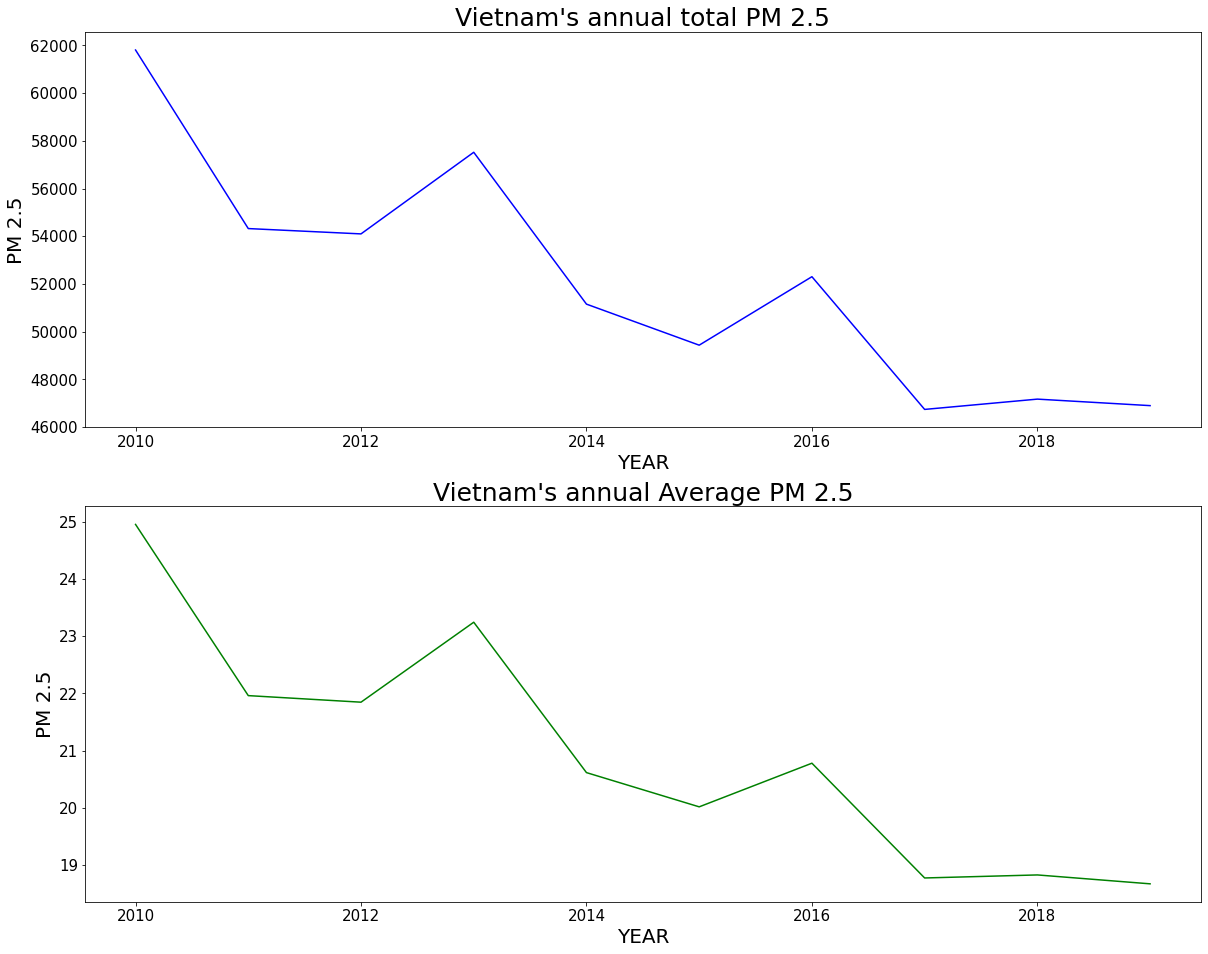

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 16))

# Plotting the annual air pollution values 
ax0 = sns.lineplot(data=df_air_gb, x='YEAR', y='AIR_POLLUTION', color='blue', ci=None, ax=axes[0])
ax0.set_xlabel('YEAR', fontsize=20)
ax0.set_ylabel('PM 2.5', fontsize=20)
ax0.set_title(f"Vietnam's annual total PM 2.5", 
                fontsize=25)
ax0.tick_params(axis='both', which='major', labelsize=15)
ax0.tick_params(axis='both', which='minor', labelsize=12)   

# # Plotting the annual air pollution growth
# ax1 = sns.lineplot(data=df_air_gb, x='YEAR', y='AIR_POLLUTION_PCT_CHANGE', color='green', ci=None, ax=axes[1])
# ax1.set_xlabel('YEAR', fontsize=20)
# ax1.set_ylabel('Air Pollution Growth (%)', fontsize=20)
# ax1.set_title(f"Vietnam's annual Air Pollution Growth", 
#                 fontsize=25)
# ax1.tick_params(axis='both', which='major', labelsize=15)
# ax1.tick_params(axis='both', which='minor', labelsize=12) 

# Plotting the annual air pollution values 
ax1 = sns.lineplot(data=df_air_gb, x='YEAR', y='AIR_POLLUTION_AVG', color='green', ci=None, ax=axes[1])
ax1.set_xlabel('YEAR', fontsize=20)
ax1.set_ylabel('PM 2.5', fontsize=20)
ax1.set_title(f"Vietnam's annual Average PM 2.5", 
                fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=12)   


# # Plotting the annual air pollution growth
# ax3 = sns.lineplot(data=df_air_gb, x='YEAR', y='AIR_AVG_PCT_CHANGE', color='green', ci=None, ax=axes[3])
# ax3.set_xlabel('YEAR', fontsize=20)
# ax3.set_ylabel('Air Pollution Growth (%)', fontsize=20)
# ax3.set_title(f"Vietnam's annual average Air Pollution Growth", 
#                 fontsize=25)
# ax3.tick_params(axis='both', which='major', labelsize=15)
# ax3.tick_params(axis='both', which='minor', labelsize=12) 


#### Chloropleth gif of annual log luminosity, air pollution and average temp

In [22]:
# The code in this block produces a timelapse animation of Vietnam's luminosity 
# choropleth map between 2014-2021
%matplotlib notebook 

# Initialize and configure Writer object 
# we choose our animation to have 2 frames per second 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

fig, [axes, caxes] = plt.subplots(nrows=2, ncols=3, figsize=[40, 15], 
                                  gridspec_kw={"height_ratios":[50,1]})

  
cmap_lumi = cm.gray
norm_lumi = colors.Normalize(vmin=df_air_log.LOG_LUMINOSITY_SUM.min(), 
                             vmax=df_air_log.LOG_LUMINOSITY_SUM.max())
cb_lumi = colorbar.ColorbarBase(caxes[0], cmap=cmap_lumi,
                                  norm=norm_lumi,
                                  orientation='horizontal')
  
cmap_avg_temp = cm.Reds
norm_avg_temp = colors.Normalize(vmin=df_air_log.AVERAGE_TEMPERATURE.min(), 
                                 vmax=df_air_log.AVERAGE_TEMPERATURE.max())
cb_avg_temp = colorbar.ColorbarBase(caxes[1], cmap=cmap_avg_temp,
                                      norm=norm_avg_temp,
                                      orientation='horizontal')

cmap_air_avg = cm.Wistia
norm_air_avg = colors.Normalize(vmin=df_air_log.AIR_POLLUTION_AVG.min(), 
                                vmax=df_air_log.AIR_POLLUTION_AVG.max())
cb_air_avg = colorbar.ColorbarBase(caxes[2], cmap=cmap_air_avg,
                                   norm=norm_air_avg,
                                   orientation='horizontal')

def animate(i: int) -> None:
  """This function produces Black Marble and CSM choropleth plots of 
  a single year-month instance of Log Luminosity"""

  # Declaring global variables df and df_poly
  global df_air_log, df_poly

  # year month instance 
  year = df_air_log.YEAR.unique()[i]
  print(year)

  # Producing poly DataFrame and calculating BM and CSM's log luminosity 
  df_choro = df_air_log[(df_air_log['YEAR'] == year)]
  poly = pd.merge(df_poly[['GID_2', 'geometry']], 
                  df_choro,
                  on=['GID_2'],
                  how='left')
  
  # Plotting BM and CSM log luminosity on separate axes 
  poly.plot(column='LOG_LUMINOSITY_SUM', ax=axes[0], cmap=cm.gray, legend=False)
  poly.plot(column='AVERAGE_TEMPERATURE', ax=axes[1], cmap=cm.Reds, legend=False)
  poly.plot(column='AIR_POLLUTION_AVG', ax=axes[2], cmap=cm.Wistia, legend=False)

  axes[0].set_title(f'Log Luminosity Sum in {year}', fontsize=25)
  axes[1].set_title(f'Average Temperature in {year}', fontsize=25)
  axes[2].set_title(f'Average PM 2.5 in {year}', fontsize=25)

  axes[0].axis('off') # removing the grid 
  axes[1].axis('off')
  axes[2].axis('off')

# Initialize animation object 
ani = animation.FuncAnimation(fig, animate, frames=df_air_log.YEAR.nunique(), repeat=True)

# Exporting the animation as an MP4 file 
ani.save(os.path.join(dir, 'yearly_all.mp4'), writer=writer)

plt.show()

<IPython.core.display.Javascript object>

2014
2014
2015
2016
2017
2018
2019


#### Regressions

In [28]:
pop.columns = pop.columns.str.upper()
df_air_log = pd.merge(df_air_log, pop[['GID_2', 'YEAR', 'POPULATION']],
                      on=['GID_2', 'YEAR'], 
                      how='left')
df_air_log['LOG_LUMI_PER_POP'] = df_air_log['LOG_LUMINOSITY_SUM'] / df_air_log['POPULATION']
df_air_log['LUMI_PER_POP'] = df_air_log['LUMINOSITY_SUM'] / df_air_log['POPULATION']
df_air_log['PM_25_SUM_POP'] = df_air_log['AIR_POLLUTION'] / df_air_log['POPULATION']
df_air_log['PM_25_AVG_POP'] = df_air_log['AIR_POLLUTION_AVG'] / df_air_log['POPULATION']

In [29]:
df_air_log

,GID_2,NAME_2,GID_1,NAME_1,YEAR,TIME_ENCODE,LOG_LUMINOSITY_SUM,AVERAGE_TEMPERATURE,LUMINOSITY_SUM,MAX_TEMPERATURE,AIR_POLLUTION,AIR_POLLUTION_AVG,POPULATION,LOG_LUMI_PER_POP,LUMI_PER_POP,PM_25_SUM_POP,PM_25_AVG_POP
0,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2014,0,8.005595,26.985232,2997.682434,35.903061,97.054009,25.112648,185171.470215,0.000043,0.016189,0.000524,0.000136
1,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2015,1,8.111081,27.459351,3331.176609,36.308628,102.461763,26.508628,185816.690918,0.000044,0.017927,0.000551,0.000143
2,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2016,2,8.273444,27.609726,3918.419073,38.085022,94.145195,24.388215,185891.595703,0.000045,0.021079,0.000506,0.000131
3,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2017,3,8.166455,26.708063,3520.841143,34.158653,89.128784,23.114752,186168.364258,0.000044,0.018912,0.000479,0.000124
4,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2018,4,8.604800,26.982952,5457.796585,35.335587,88.021965,22.823974,186198.990234,0.000046,0.029312,0.000473,0.000123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4255,VNM.9.9_1,Thu?n An,VNM.9_1,Bình D??ng,2015,1,11.278106,27.192544,79071.341309,36.110855,18.299969,26.478746,573542.727539,0.000020,0.137865,0.000032,0.000046
4256,VNM.9.9_1,Thu?n An,VNM.9_1,Bình D??ng,2016,2,11.324940,27.345864,82862.642578,37.579525,19.091774,27.624434,614702.115234,0.000018,0.134801,0.000031,0.000045
4257,VNM.9.9_1,Thu?n An,VNM.9_1,Bình D??ng,2017,3,11.361102,26.724937,85914.017090,36.245647,17.525928,25.358767,658302.111328,0.000017,0.130508,0.000027,0.000039
4258,VNM.9.9_1,Thu?n An,VNM.9_1,Bình D??ng,2018,4,11.434701,27.040146,92475.668945,36.647247,17.471262,25.279667,703598.059570,0.000016,0.131433,0.000025,0.000036


##### Total Pollution

In [ ]:
df_panel = df_air_log[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'LOG_LUMINOSITY_SUM', 
                       'AVERAGE_TEMPERATURE', 'MAX_TEMPERATURE',
                       'AIR_POLLUTION']]
log_lumi_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LOG_LUMINOSITY_SUM'], 
                                                       Y_var='AIR_POLLUTION',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

avg_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['AVERAGE_TEMPERATURE'], 
                                                       Y_var='AIR_POLLUTION',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

max_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['MAX_TEMPERATURE'], 
                                                       Y_var='AIR_POLLUTION',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

stargazer = Stargazer([log_lumi_pollution_fixed_prov_y,
                       avg_temp_pollution_fixed_prov_y,
                       max_temp_pollution_fixed_prov_y])
# HTML(stargazer.render_html())
stargazer.render_latex()

['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', '

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lccc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{3}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{3-4}\n\\\\[-1.8ex] & (1) & (2) & (3) \\\\\n\\hline \\\\[-1.8ex]\n AVERAGE_TEMPERATURE & & -17.014$^{***}$ & \\\\\n  & & (0.874) & \\\\\n Intercept & 185.888$^{***}$ & 485.770$^{***}$ & 202.227$^{***}$ \\\\\n  & (7.395) & (20.032) & (21.486) \\\\\n LOG_LUMINOSITY_SUM & -9.084$^{***}$ & & \\\\\n  & (0.498) & & \\\\\n MAX_TEMPERATURE & & & -2.454$^{***}$ \\\\\n  & & & (0.577) \\\\\n Q("0") & -0.312$^{}$ & -7.531$^{***}$ & 3.737$^{}$ \\\\\n  & (2.407) & (2.480) & (2.540) \\\\\n Q("1") & -0.569$^{}$ & -0.951$^{}$ & 2.773$^{}$ \\\\\n  & (2.393) & (2.391) & (2.489) \\\\\n Q("2") & 4.379$^{*}$ & 2.797$^{}$ & 6.825$^{***}$ \\\\\n  & (2.389) & (2.393) & (2.489) \\\\\n Q("3") & -2.151$^{}$ & -14.366$^{***}$ & -2.636$^{}$ \\\\\n  & (2.384) & (2.488) & (2.545) \\\\\n Q("4") & -0.148$^{}$ & -11.602$^{***}$ & 

In [ ]:
df_panel = df_air_pct[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'YEAR', 'LUMINOSITY_PCT_CHANGE',
                       'AIR_POLLUTION_PCT_CHANGE', 'AVG_TEMP_PCT_CHANGE',
                       'MAX_TEMP_PCT_CHANGE']]
pct_lumi_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LUMINOSITY_PCT_CHANGE'], 
                                                       Y_var='AIR_POLLUTION_PCT_CHANGE',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

pct_avg_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['AVG_TEMP_PCT_CHANGE'], 
                                                       Y_var='AIR_POLLUTION_PCT_CHANGE',
                                                       effect_vars_list=['NAME_1','TIME_ENCODE'])

pct_max_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['MAX_TEMP_PCT_CHANGE'], 
                                                       Y_var='AIR_POLLUTION_PCT_CHANGE',
                                                       effect_vars_list=['NAME_1','TIME_ENCODE'])

stargazer = Stargazer([pct_lumi_pollution_fixed_prov_y,
                       pct_avg_temp_pollution_fixed_prov_y,
                       pct_max_temp_pollution_fixed_prov_y])
# HTML(stargazer.render_html())
stargazer.render_latex()

['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', '

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lccc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{3}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{3-4}\n\\\\[-1.8ex] & (1) & (2) & (3) \\\\\n\\hline \\\\[-1.8ex]\n AVG_TEMP_PCT_CHANGE & & 0.310$^{***}$ & \\\\\n  & & (0.024) & \\\\\n Intercept & -1.227$^{}$ & -2.252$^{***}$ & -1.144$^{}$ \\\\\n  & (0.761) & (0.745) & (0.765) \\\\\n LUMINOSITY_PCT_CHANGE & -0.000$^{*}$ & & \\\\\n  & (0.000) & & \\\\\n MAX_TEMP_PCT_CHANGE & & & -0.028$^{}$ \\\\\n  & & & (0.024) \\\\\n Q("1") & -0.840$^{***}$ & -0.392$^{}$ & -0.897$^{***}$ \\\\\n  & (0.313) & (0.306) & (0.316) \\\\\n Q("2") & 7.340$^{***}$ & 7.161$^{***}$ & 7.266$^{***}$ \\\\\n  & (0.312) & (0.305) & (0.318) \\\\\n Q("3") & -7.047$^{***}$ & -6.033$^{***}$ & -7.181$^{***}$ \\\\\n  & (0.313) & (0.315) & (0.328) \\\\\n Q("4") & 1.286$^{***}$ & 2.329$^{***}$ & 1.142$^{***}$ \\\\\n  & (0.316) & (0.319) & (0.339) \\\\\n Q("??k L?k") & 1.378$^{}$ & 1.4

In [26]:
df_air_log

,GID_2,NAME_2,GID_1,NAME_1,YEAR,TIME_ENCODE,LOG_LUMINOSITY_SUM,AVERAGE_TEMPERATURE,LUMINOSITY_SUM,MAX_TEMPERATURE,AIR_POLLUTION,AIR_POLLUTION_AVG,POPULATION,LUMI_PER_POP,PM_25_SUM_POP,PM_25_AVG_POP
0,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2014,0,8.005595,26.985232,2997.682434,35.903061,97.054009,25.112648,185171.470215,0.016189,0.000524,0.000136
1,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2015,1,8.111081,27.459351,3331.176609,36.308628,102.461763,26.508628,185816.690918,0.017927,0.000551,0.000143
2,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2016,2,8.273444,27.609726,3918.419073,38.085022,94.145195,24.388215,185891.595703,0.021079,0.000506,0.000131
3,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2017,3,8.166455,26.708063,3520.841143,34.158653,89.128784,23.114752,186168.364258,0.018912,0.000479,0.000124
4,VNM.1.10_1,Tho?i S?n,VNM.1_1,An Giang,2018,4,8.604800,26.982952,5457.796585,35.335587,88.021965,22.823974,186198.990234,0.029312,0.000473,0.000123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4255,VNM.9.9_1,Thu?n An,VNM.9_1,Bình D??ng,2015,1,11.278106,27.192544,79071.341309,36.110855,18.299969,26.478746,573542.727539,0.137865,0.000032,0.000046
4256,VNM.9.9_1,Thu?n An,VNM.9_1,Bình D??ng,2016,2,11.324940,27.345864,82862.642578,37.579525,19.091774,27.624434,614702.115234,0.134801,0.000031,0.000045
4257,VNM.9.9_1,Thu?n An,VNM.9_1,Bình D??ng,2017,3,11.361102,26.724937,85914.017090,36.245647,17.525928,25.358767,658302.111328,0.130508,0.000027,0.000039
4258,VNM.9.9_1,Thu?n An,VNM.9_1,Bình D??ng,2018,4,11.434701,27.040146,92475.668945,36.647247,17.471262,25.279667,703598.059570,0.131433,0.000025,0.000036


In [30]:
df_panel = df_air_log[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'LUMI_PER_POP', 'LOG_LUMI_PER_POP',
                       'PM_25_SUM_POP', 'PM_25_AVG_POP']]
lumi_pm_sum_pop_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LUMI_PER_POP'], 
                                                       Y_var='PM_25_SUM_POP',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

log_lumi_pm_sum_pop_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LOG_LUMI_PER_POP'], 
                                                       Y_var='PM_25_SUM_POP',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])



stargazer = Stargazer([lumi_pm_sum_pop_prov_y,
                       log_lumi_pm_sum_pop_prov_y])
HTML(stargazer.render_html())
# stargazer.render_latex()

['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', '

In [31]:
df_panel = df_air_log[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'LUMI_PER_POP', 'LOG_LUMI_PER_POP',
                       'PM_25_SUM_POP', 'PM_25_AVG_POP']]
lumi_pm_avg_pop_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LUMI_PER_POP'], 
                                                       Y_var='PM_25_AVG_POP',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

log_lumi_pm_avg_pop_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LOG_LUMI_PER_POP'], 
                                                       Y_var='PM_25_AVG_POP',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])



stargazer = Stargazer([lumi_pm_avg_pop_prov_y,
                       log_lumi_pm_avg_pop_prov_y])
HTML(stargazer.render_html())
# stargazer.render_latex()

['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', '

##### Average Pollution

In [ ]:
df_panel = df_air_log[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'LOG_LUMINOSITY_SUM', 
                       'AVERAGE_TEMPERATURE', 'MAX_TEMPERATURE',
                       'AIR_POLLUTION_AVG']]
log_lumi_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LOG_LUMINOSITY_SUM'], 
                                                       Y_var='AIR_POLLUTION_AVG',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

avg_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['AVERAGE_TEMPERATURE'], 
                                                       Y_var='AIR_POLLUTION_AVG',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

max_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['MAX_TEMPERATURE'], 
                                                       Y_var='AIR_POLLUTION_AVG',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

stargazer = Stargazer([log_lumi_pollution_fixed_prov_y,
                       avg_temp_pollution_fixed_prov_y,
                       max_temp_pollution_fixed_prov_y])
# HTML(stargazer.render_html())
stargazer.render_latex()

['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', '

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lccc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{3}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{3-4}\n\\\\[-1.8ex] & (1) & (2) & (3) \\\\\n\\hline \\\\[-1.8ex]\n AVERAGE_TEMPERATURE & & 0.234$^{***}$ & \\\\\n  & & (0.029) & \\\\\n Intercept & 16.532$^{***}$ & 12.107$^{***}$ & 11.248$^{***}$ \\\\\n  & (0.248) & (0.655) & (0.672) \\\\\n LOG_LUMINOSITY_SUM & 0.087$^{***}$ & & \\\\\n  & (0.017) & & \\\\\n MAX_TEMPERATURE & & & 0.168$^{***}$ \\\\\n  & & & (0.018) \\\\\n Q("0") & 2.017$^{***}$ & 2.151$^{***}$ & 2.123$^{***}$ \\\\\n  & (0.081) & (0.081) & (0.079) \\\\\n Q("1") & 1.398$^{***}$ & 1.425$^{***}$ & 1.420$^{***}$ \\\\\n  & (0.080) & (0.078) & (0.078) \\\\\n Q("2") & 2.157$^{***}$ & 2.198$^{***}$ & 2.191$^{***}$ \\\\\n  & (0.080) & (0.078) & (0.078) \\\\\n Q("3") & 0.122$^{}$ & 0.299$^{***}$ & 0.270$^{***}$ \\\\\n  & (0.080) & (0.081) & (0.080) \\\\\n Q("4") & 0.162$^{**}$ & 0.322$^{***

In [ ]:
df_panel = df_air_pct[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'YEAR', 'LUMINOSITY_PCT_CHANGE',
                       'AIR_AVG_PCT_CHANGE', 'AVG_TEMP_PCT_CHANGE',
                       'MAX_TEMP_PCT_CHANGE']]
pct_lumi_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LUMINOSITY_PCT_CHANGE'], 
                                                       Y_var='AIR_AVG_PCT_CHANGE',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

pct_avg_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['AVG_TEMP_PCT_CHANGE'], 
                                                       Y_var='AIR_AVG_PCT_CHANGE',
                                                       effect_vars_list=['NAME_1','TIME_ENCODE'])

pct_max_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['MAX_TEMP_PCT_CHANGE'], 
                                                       Y_var='AIR_AVG_PCT_CHANGE',
                                                       effect_vars_list=['NAME_1','TIME_ENCODE'])

stargazer = Stargazer([pct_lumi_pollution_fixed_prov_y,
                       pct_avg_temp_pollution_fixed_prov_y,
                       pct_max_temp_pollution_fixed_prov_y])
HTML(stargazer.render_html())
# stargazer.render_latex()

['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', '

### Urban / Rural

In [11]:
df = process_data(bm, avg_temp, max_temp, air, air_avg,
                  yearly=True, pop_zone=True)

df['TIME_ENCODE'] = df['YEAR'].astype('category').cat.codes.astype(str)


cleaning data

aggregating data

combining data

rest of steps


In [12]:
df.head()

,GID_2,POP_ZONE,YEAR,COUNTRY,GID_1,NAME_1,NAME_2,LUMINOSITY_SUM,AVERAGE_TEMPERATURE,MAX_TEMPERATURE,AIR_POLLUTION,AIR_POLLUTION_AVG,LOG_LUMINOSITY_SUM,LUMINOSITY_PCT_CHANGE,AVG_TEMP_PCT_CHANGE,MAX_TEMP_PCT_CHANGE,AIR_POLLUTION_PCT_CHANGE,AIR_AVG_PCT_CHANGE,POP_ZONE_ENCODE,TIME_ENCODE
0,VNM.1.10_1,rural,2014,Vietnam,VNM.1_1,An Giang,Tho?i S?n,539.051075,26.992985,35.903061,63.223961,25.053337,6.289810,NaN,NaN,NaN,NaN,NaN,0,0
1,VNM.1.10_1,rural,2015,Vietnam,VNM.1_1,An Giang,Tho?i S?n,671.786930,27.478260,36.308628,66.771805,26.459219,6.509941,24.623985,1.797782,1.129617,5.611550,5.611555,0,1
2,VNM.1.10_1,rural,2016,Vietnam,VNM.1_1,An Giang,Tho?i S?n,820.089788,27.622874,38.085022,61.288029,24.286200,6.709414,22.075877,0.526285,4.892484,-8.212712,-8.212712,0,2
3,VNM.1.10_1,rural,2017,Vietnam,VNM.1_1,An Giang,Tho?i S?n,617.190737,26.711018,34.158653,57.978256,22.974657,6.425178,-24.741078,-3.301091,-10.309483,-5.400357,-5.400361,0,3
4,VNM.1.10_1,rural,2018,Vietnam,VNM.1_1,An Giang,Tho?i S?n,1173.742737,26.989017,35.335587,57.262222,22.690920,7.067953,90.175041,1.040766,3.445491,-1.235004,-1.235001,0,4


In [13]:
df_air_log = df[['COUNTRY', 'GID_2', 'NAME_2', 'GID_1', 'NAME_1', 'YEAR', 'TIME_ENCODE',
                 'LUMINOSITY_SUM', 'LOG_LUMINOSITY_SUM', 'AVERAGE_TEMPERATURE', 
                 'MAX_TEMPERATURE', 'AIR_POLLUTION', 'POP_ZONE', 
                 'AIR_POLLUTION_AVG']]
df_air_log = df_air_log[df_air_log['YEAR'].between(2014, 2019)]

df_air_pct = df[['COUNTRY', 'GID_2', 'NAME_2', 'YEAR', 'NAME_1', 'TIME_ENCODE',
                 'LUMINOSITY_PCT_CHANGE', 'AIR_POLLUTION_PCT_CHANGE', 
                 'AVG_TEMP_PCT_CHANGE', 'MAX_TEMP_PCT_CHANGE', 'POP_ZONE', 
                 'AIR_AVG_PCT_CHANGE']]
df_air_pct = df_air_pct[df_air_pct['YEAR'].between(2015, 2019)]                 

df_air_pct = df_air_pct.dropna().reset_index(drop=True)
df_air_pct['YEAR'] = df_air_pct['YEAR'].astype(int)

#### Lineplots

In [14]:
merge_gb_cols = ['POP_ZONE', 'YEAR']
df_air_gb = df_air_log.groupby(merge_gb_cols)\
                  .agg(AIR_POLLUTION=('AIR_POLLUTION', 'sum'),
                       LUMINOSITY_SUM=('LUMINOSITY_SUM', 'sum'),
                       AVERAGE_TEMPERATURE=('AVERAGE_TEMPERATURE', 'mean'),
                       MAX_TEMPERATURE=('MAX_TEMPERATURE', 'max'),
                       AIR_POLLUTION_AVG=('AIR_POLLUTION_AVG', 'mean'))\
                  .reset_index()
df_air_gb = df_air_gb[df_air_gb['YEAR'].between(2010, 2019)]

gb_cols = ['POP_ZONE']
df_air_gb['LUMINOSITY_PCT_CHANGE'] = \
                100*(df_air_gb.groupby(gb_cols)['LUMINOSITY_SUM'].apply(pd.Series.pct_change))
df_air_gb['AVG_TEMP_PCT_CHANGE'] = \
                100*(df_air_gb.groupby(gb_cols)['AVERAGE_TEMPERATURE'].apply(pd.Series.pct_change))
df_air_gb['MAX_TEMP_PCT_CHANGE'] = \
                100*(df_air_gb.groupby(gb_cols)['MAX_TEMPERATURE'].apply(pd.Series.pct_change))
df_air_gb['AIR_POLLUTION_PCT_CHANGE'] = \
                100*(df_air_gb.groupby(gb_cols)['AIR_POLLUTION'].apply(pd.Series.pct_change))
df_air_gb['AIR_AVG_PCT_CHANGE'] = \
                100*(df_air_gb.groupby(gb_cols)['AIR_POLLUTION_AVG'].apply(pd.Series.pct_change))

df_air_gb

,POP_ZONE,YEAR,AIR_POLLUTION,LUMINOSITY_SUM,AVERAGE_TEMPERATURE,MAX_TEMPERATURE,AIR_POLLUTION_AVG,LUMINOSITY_PCT_CHANGE,AVG_TEMP_PCT_CHANGE,MAX_TEMP_PCT_CHANGE,AIR_POLLUTION_PCT_CHANGE,AIR_AVG_PCT_CHANGE
0,rural,2014,39615.525869,5.848707e+06,24.002491,39.776001,20.200477,NaN,NaN,NaN,NaN,NaN
1,rural,2015,38145.735294,7.405919e+06,24.532340,41.641701,19.608971,26.624893,2.207472,4.690516,-3.710138,-2.928177
2,rural,2016,40704.928275,6.695210e+06,24.515738,40.405575,20.374341,-9.596498,-0.067671,-2.968481,6.708988,3.903162
3,rural,2017,36189.707996,8.323912e+06,23.970116,39.871021,18.391308,24.326372,-2.225599,-1.322970,-11.092564,-9.732992
4,rural,2018,36614.390586,1.148772e+07,24.092929,40.108780,18.445971,38.008664,0.512357,0.596319,1.173490,0.297222
5,rural,2019,36430.195717,1.104436e+07,24.806168,41.874538,18.294150,-3.859421,2.960369,4.402424,-0.503067,-0.823056
6,urban,2014,11543.195319,1.187015e+07,24.279449,39.740044,20.899076,NaN,NaN,NaN,NaN,NaN
7,urban,2015,11292.854343,1.353334e+07,24.812321,41.623676,20.301048,14.011556,2.194747,4.739886,-2.168732,-2.861505
8,urban,2016,11603.196606,1.373900e+07,24.787682,40.479725,21.057682,1.519619,-0.099303,-2.748319,2.748130,3.727069
9,urban,2017,10556.540952,1.562804e+07,24.244768,39.904156,19.034828,13.749511,-2.190257,-1.421870,-9.020408,-9.606250


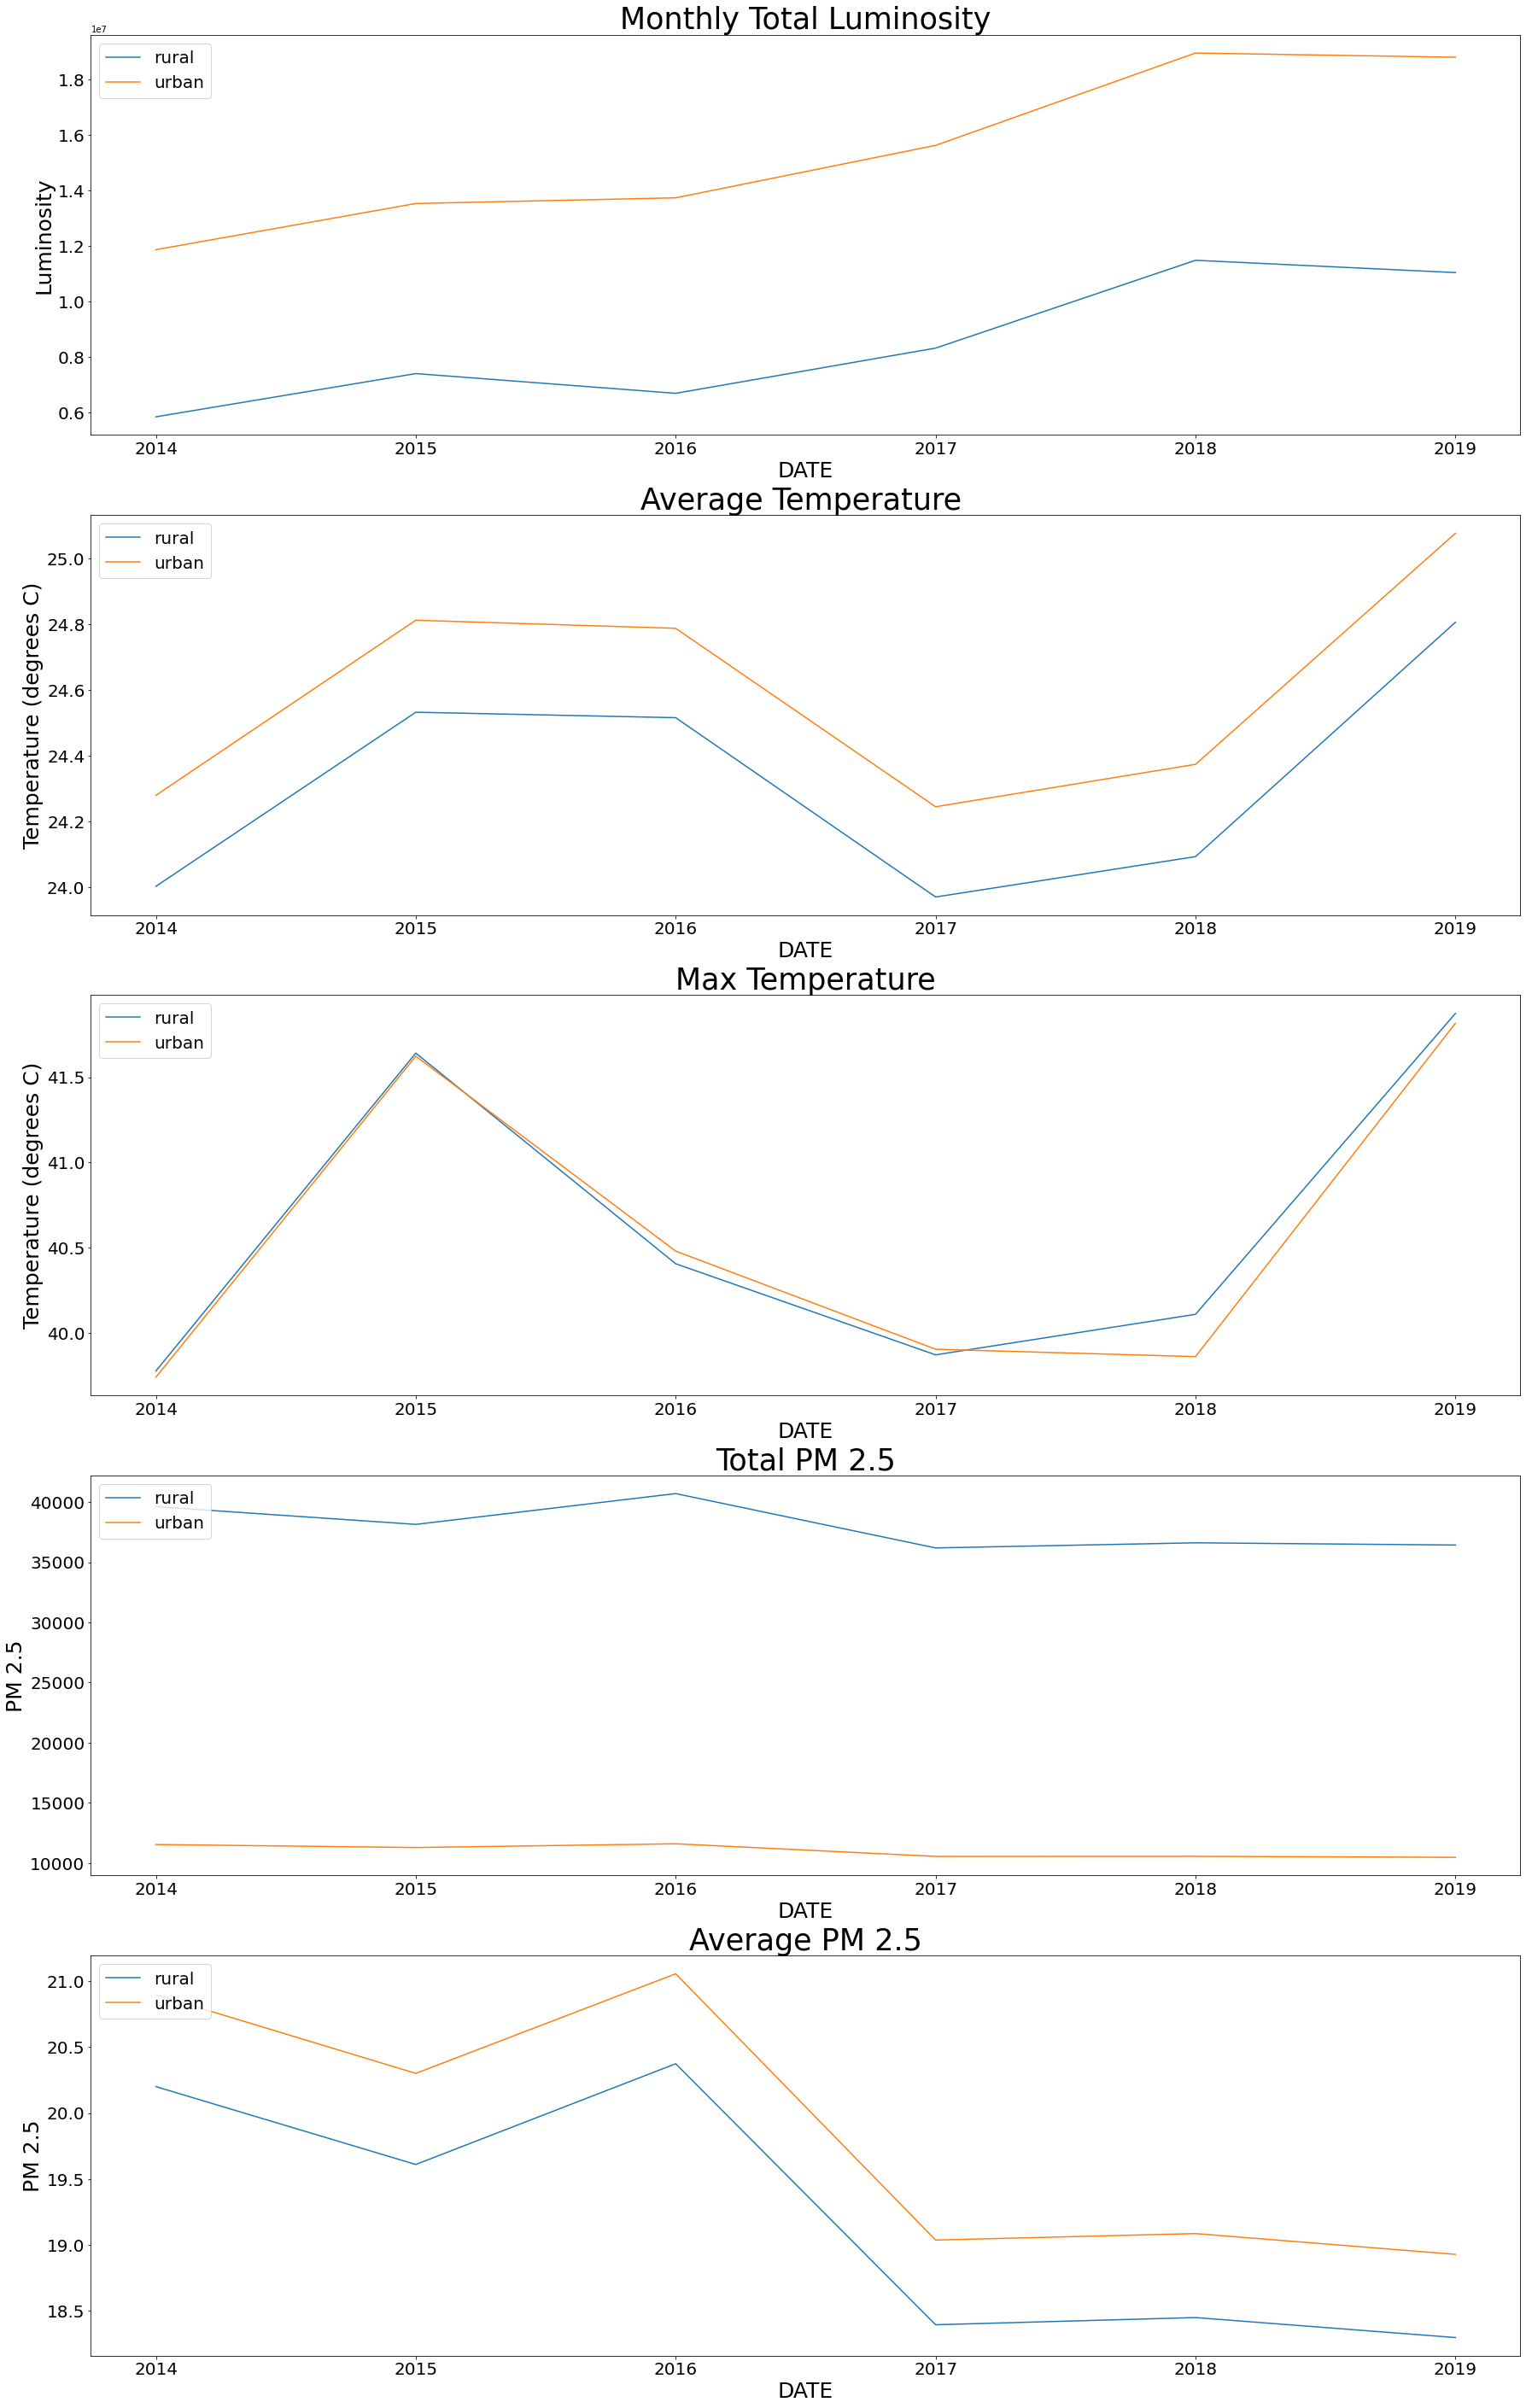

In [15]:
# df['DATE'] = pd.to_datetime(df.YEAR.astype(str)+' '+ df.MONTH.astype(str))
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(30, 50))

# Plotting the annual luminosity 
ax0 = sns.lineplot(data=df_air_gb, x='YEAR', y='LUMINOSITY_SUM', hue='POP_ZONE',
                   color='blue', ci=None, ax=axes[0])
ax0.set_xlabel('DATE', fontsize=25)
ax0.set_ylabel('Luminosity', fontsize=25)
ax0.set_title(f"Monthly Total Luminosity", 
              fontsize=35)
ax0.tick_params(axis='both', which='major', labelsize=20)
ax0.tick_params(axis='both', which='minor', labelsize=15)
ax0.legend(loc='best', fontsize=20) 

# Plotting the annual average temperature
ax1 = sns.lineplot(data=df_air_gb, x='YEAR', y='AVERAGE_TEMPERATURE', hue='POP_ZONE',
                   color='orange', ci=None, ax=axes[1])
ax1.set_xlabel('DATE', fontsize=25)
ax1.set_ylabel('Temperature (degrees C)', fontsize=25)
ax1.set_title(f"Average Temperature ", 
              fontsize=35)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.legend(loc='best', fontsize=20)     

# Plotting the annual max temperature 
ax2 = sns.lineplot(data=df_air_gb, x='YEAR', y='MAX_TEMPERATURE', hue='POP_ZONE',
                   color='blue', ci=None, ax=axes[2])
ax2.set_xlabel('DATE', fontsize=25)
ax2.set_ylabel('Temperature (degrees C)', fontsize=25)
ax2.set_title(f"Max Temperature", 
              fontsize=35)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.legend(loc='upper left', fontsize=20)


# Plotting the Montly Percentage Change in Luminosity
ax3 = sns.lineplot(data=df_air_gb, x='YEAR', y='AIR_POLLUTION', hue='POP_ZONE',
                   color='blue', ci=None, ax=axes[3])
ax3.set_xlabel('DATE', fontsize=25)
ax3.set_ylabel('PM 2.5', fontsize=25)
ax3.set_title(f"Total PM 2.5", 
              fontsize=35)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.legend(loc='upper left', fontsize=20)

# Plotting the Montly Percentage Change in Luminosity
ax4 = sns.lineplot(data=df_air_gb, x='YEAR', y='AIR_POLLUTION_AVG', hue='POP_ZONE',
                   color='blue', ci=None, ax=axes[4])
ax4.set_xlabel('DATE', fontsize=25)
ax4.set_ylabel('PM 2.5', fontsize=25)
ax4.set_title(f"Average PM 2.5", 
              fontsize=35)
ax4.tick_params(axis='both', which='major', labelsize=20)
ax4.tick_params(axis='both', which='minor', labelsize=15)
ax4.legend(loc='upper left', fontsize=20)

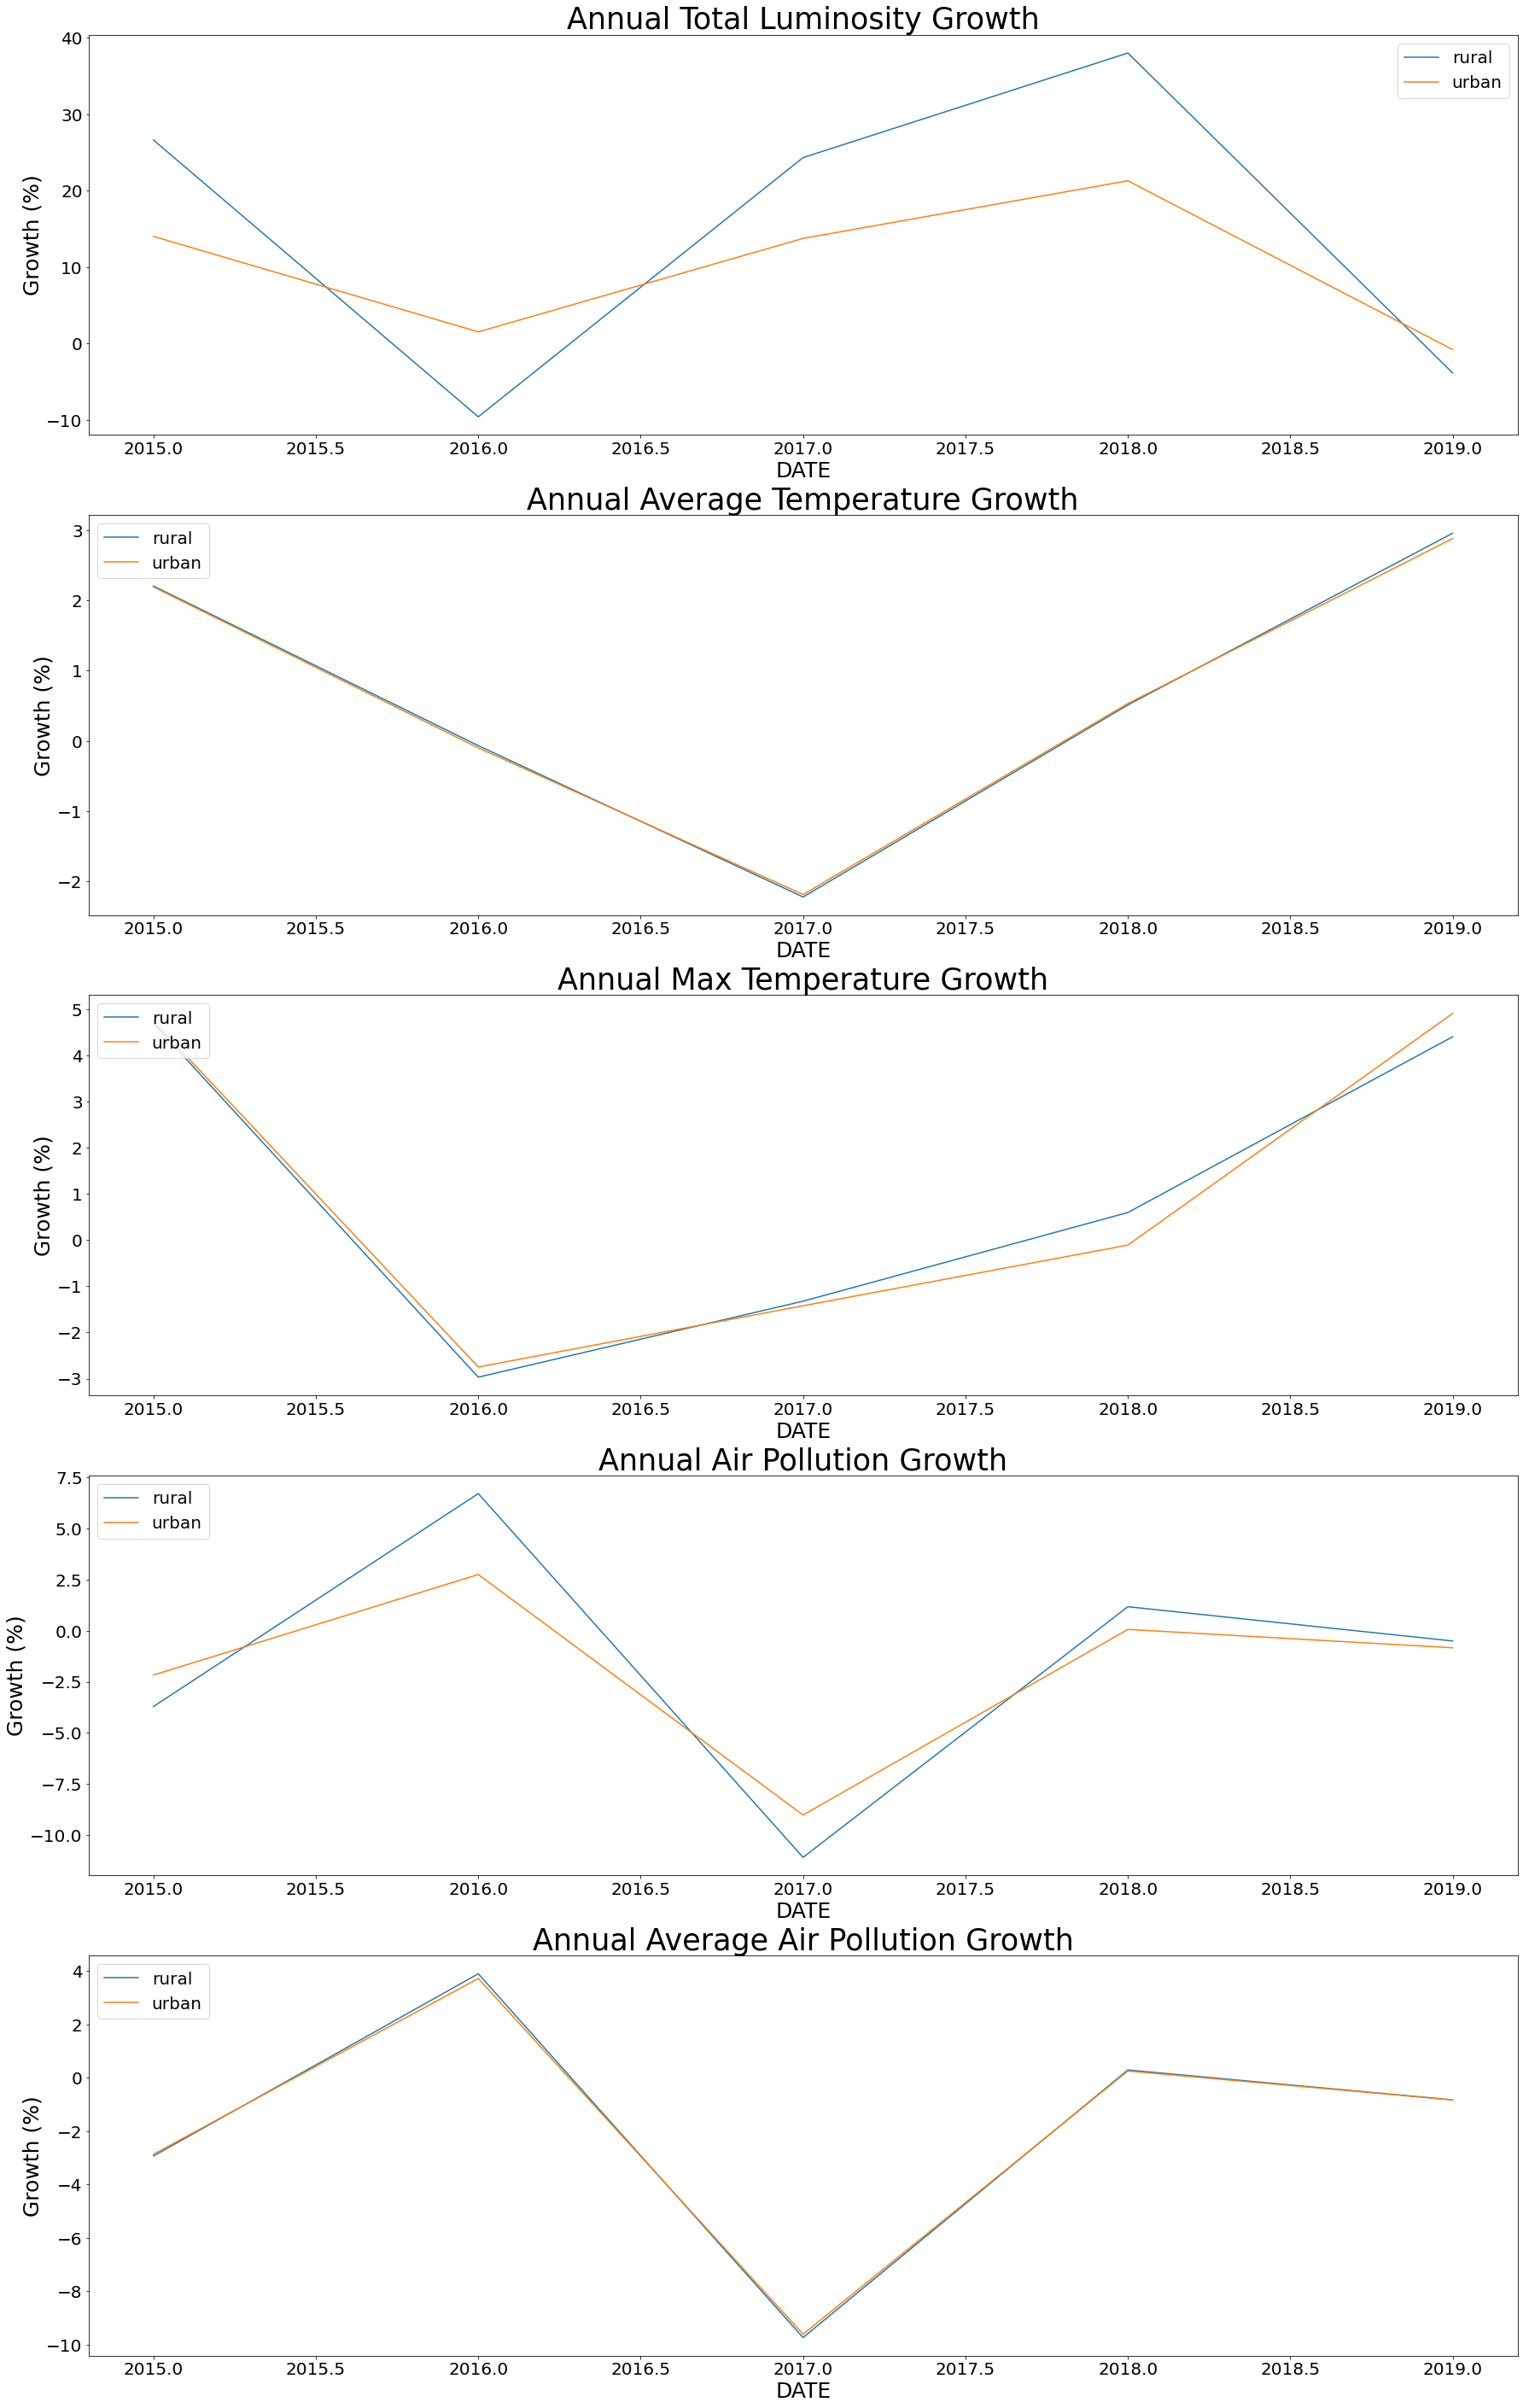

In [ ]:
# df['DATE'] = pd.to_datetime(df.YEAR.astype(str)+' '+ df.MONTH.astype(str))
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(30, 50))

# Plotting the annual luminosity 
ax0 = sns.lineplot(data=df_air_gb, x='YEAR', y='LUMINOSITY_PCT_CHANGE', hue='POP_ZONE',
                   color='blue', ci=None, ax=axes[0])
ax0.set_xlabel('DATE', fontsize=25)
ax0.set_ylabel('Growth (%)', fontsize=25)
ax0.set_title(f"Annual Total Luminosity Growth", 
              fontsize=35)
ax0.tick_params(axis='both', which='major', labelsize=20)
ax0.tick_params(axis='both', which='minor', labelsize=15)
ax0.legend(loc='best', fontsize=20) 

# Plotting the annual average temperature
ax1 = sns.lineplot(data=df_air_gb, x='YEAR', y='AVG_TEMP_PCT_CHANGE', hue='POP_ZONE',
                   color='orange', ci=None, ax=axes[1])
ax1.set_xlabel('DATE', fontsize=25)
ax1.set_ylabel('Growth (%)', fontsize=25)
ax1.set_title(f"Annual Average Temperature Growth", 
              fontsize=35)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.legend(loc='best', fontsize=20)     

# Plotting the annual max temperature 
ax2 = sns.lineplot(data=df_air_gb, x='YEAR', y='MAX_TEMP_PCT_CHANGE', hue='POP_ZONE',
                   color='blue', ci=None, ax=axes[2])
ax2.set_xlabel('DATE', fontsize=25)
ax2.set_ylabel('Growth (%)', fontsize=25)
ax2.set_title(f"Annual Max Temperature Growth", 
              fontsize=35)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.legend(loc='upper left', fontsize=20)


# Plotting the Montly Percentage Change in Luminosity
ax3 = sns.lineplot(data=df_air_gb, x='YEAR', y='AIR_POLLUTION_PCT_CHANGE', hue='POP_ZONE',
                   color='blue', ci=None, ax=axes[3])
ax3.set_xlabel('DATE', fontsize=25)
ax3.set_ylabel('Growth (%)', fontsize=25)
ax3.set_title(f"Annual Air Pollution Growth", 
              fontsize=35)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.legend(loc='upper left', fontsize=20)

# Plotting the Montly Percentage Change in Luminosity
ax4 = sns.lineplot(data=df_air_gb, x='YEAR', y='AIR_AVG_PCT_CHANGE', hue='POP_ZONE',
                   color='blue', ci=None, ax=axes[4])
ax4.set_xlabel('DATE', fontsize=25)
ax4.set_ylabel('Growth (%)', fontsize=25)
ax4.set_title(f"Annual Average Air Pollution Growth", 
              fontsize=35)
ax4.tick_params(axis='both', which='major', labelsize=20)
ax4.tick_params(axis='both', which='minor', labelsize=15)
ax4.legend(loc='upper left', fontsize=20)

#### Cholorpleth gif of annual data on rural/urban areas for Log luminosity, Pollution, Ave temp

##### Urban

In [ ]:
# The code in this block produces a timelapse animation of Vietnam's luminosity 
# choropleth map between 2014-2021
%matplotlib notebook 

# Initialize and configure Writer object 
# we choose our animation to have 2 frames per second 

df_air_urban = df_air_log[df_air_log['POP_ZONE'] == 'urban']

Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

fig, [axes, caxes] = plt.subplots(nrows=2, ncols=3, figsize=[30, 15], 
                                  gridspec_kw={"height_ratios":[50,1]})

  
cmap_lumi = cm.gray
norm_lumi = colors.Normalize(vmin=df_air_urban.LOG_LUMINOSITY_SUM.min(), 
                             vmax=df_air_urban.LOG_LUMINOSITY_SUM.max())
cb_lumi = colorbar.ColorbarBase(caxes[0], cmap=cmap_lumi,
                                  norm=norm_lumi,
                                  orientation='horizontal')
  
cmap_avg_temp = cm.Reds
norm_avg_temp = colors.Normalize(vmin=df_air_urban.AVERAGE_TEMPERATURE.min(), 
                                 vmax=df_air_urban.AVERAGE_TEMPERATURE.max())
cb_avg_temp = colorbar.ColorbarBase(caxes[1], cmap=cmap_avg_temp,
                                      norm=norm_avg_temp,
                                      orientation='horizontal')
  
cmap_air = cm.Wistia
norm_air = colors.Normalize(vmin=df_air_urban.AIR_POLLUTION.min(), 
                            vmax=df_air_urban.AIR_POLLUTION.max())
cb_air = colorbar.ColorbarBase(caxes[2], cmap=cmap_air,
                               norm=norm_air,
                               orientation='horizontal')

def animate(i: int) -> None:
  """This function produces Black Marble and CSM choropleth plots of 
  a single year-month instance of Log Luminosity"""

  # Declaring global variables df and df_poly
  global df_air_urban, df_poly

  # year month instance 
  year = df_air_urban.YEAR.unique()[i]
  print(year)

  # Producing poly DataFrame and calculating BM and CSM's log luminosity 
  df_choro = df_air_urban[(df_air_urban['YEAR'] == year)]
  poly = pd.merge(df_poly[['GID_2', 'geometry']], 
                  df_choro,
                  on=['GID_2'],
                  how='left')
  
  # Plotting BM and CSM log luminosity on separate axes 
  poly.plot(column='LOG_LUMINOSITY_SUM', ax=axes[0], cmap=cm.gray, legend=False)
  poly.plot(column='AVERAGE_TEMPERATURE', ax=axes[1], cmap=cm.Reds, legend=False)
  poly.plot(column='AIR_POLLUTION', ax=axes[2], cmap=cm.Wistia, legend=False)

  axes[0].set_title(f'Urban Log Luminosity Sum in {year}', fontsize=25)
  axes[1].set_title(f'Urban Average Temperature in {year}', fontsize=25)
  axes[2].set_title(f'Urban Air Pollution Total in {year}', fontsize=25)

  axes[0].axis('off') # removing the grid 
  axes[1].axis('off')
  axes[2].axis('off')


# Initialize animation object 
ani = animation.FuncAnimation(fig, animate, frames=df_air_urban.YEAR.nunique(), repeat=True)

# Exporting the animation as an MP4 file 
ani.save(os.path.join(dir, 'yearly_urban.mp4'), writer=writer)

plt.show()

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>

2014
2014
2015
2016
2017
2018
2019


##### Rural

In [ ]:
# The code in this block produces a timelapse animation of Vietnam's luminosity 
# choropleth map between 2014-2021
%matplotlib notebook 

# Initialize and configure Writer object 
# we choose our animation to have 2 frames per second 

df_air_rural = df_air_log[df_air_log['POP_ZONE'] == 'rural']

Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

fig, [axes, caxes] = plt.subplots(nrows=2, ncols=3, figsize=[30, 15], 
                                  gridspec_kw={"height_ratios":[50,1]})

  
cmap_lumi = cm.gray
norm_lumi = colors.Normalize(vmin=df_air_rural.LOG_LUMINOSITY_SUM.min(), 
                             vmax=df_air_rural.LOG_LUMINOSITY_SUM.max())
cb_lumi = colorbar.ColorbarBase(caxes[0], cmap=cmap_lumi,
                                  norm=norm_lumi,
                                  orientation='horizontal')
  
cmap_avg_temp = cm.Reds
norm_avg_temp = colors.Normalize(vmin=df_air_rural.AVERAGE_TEMPERATURE.min(), 
                                 vmax=df_air_rural.AVERAGE_TEMPERATURE.max())
cb_avg_temp = colorbar.ColorbarBase(caxes[1], cmap=cmap_avg_temp,
                                      norm=norm_avg_temp,
                                      orientation='horizontal')
  
cmap_air = cm.Wistia
norm_air = colors.Normalize(vmin=df_air_rural.AIR_POLLUTION.min(), 
                            vmax=df_air_rural.AIR_POLLUTION.max())
cb_air = colorbar.ColorbarBase(caxes[2], cmap=cmap_air,
                               norm=norm_air,
                               orientation='horizontal')

def animate(i: int) -> None:
  """This function produces Black Marble and CSM choropleth plots of 
  a single year-month instance of Log Luminosity"""

  # Declaring global variables df and df_poly
  global df_air_rural, df_poly

  # year month instance 
  year = df_air_rural.YEAR.unique()[i]
  print(year)

  # Producing poly DataFrame and calculating BM and CSM's log luminosity 
  df_choro = df_air_rural[(df_air_rural['YEAR'] == year)]
  poly = pd.merge(df_poly[['GID_2', 'geometry']], 
                  df_choro,
                  on=['GID_2'],
                  how='left')
  
  # Plotting BM and CSM log luminosity on separate axes 
  poly.plot(column='LOG_LUMINOSITY_SUM', ax=axes[0], cmap=cm.gray, legend=False)
  poly.plot(column='AVERAGE_TEMPERATURE', ax=axes[1], cmap=cm.Reds, legend=False)
  poly.plot(column='AIR_POLLUTION', ax=axes[2], cmap=cm.Wistia, legend=False)

  axes[0].set_title(f'Rural Log Luminosity Sum in {year}', fontsize=25)
  axes[1].set_title(f'Rural Average Temperature in {year}', fontsize=25)
  axes[2].set_title(f'Rural Air Pollution Total in {year}', fontsize=25)

  axes[0].axis('off') # removing the grid 
  axes[1].axis('off')
  axes[2].axis('off')


# Initialize animation object 
ani = animation.FuncAnimation(fig, animate, frames=df_air_rural.YEAR.nunique(), repeat=True)

# Exporting the animation as an MP4 file 
ani.save(os.path.join(dir, 'yearly_rural.mp4'), writer=writer)

plt.show()

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>

2014
2014
2015
2016
2017
2018
2019


#### Regression

##### Total Air Pollution

In [ ]:
df_panel = df_air_log[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'LOG_LUMINOSITY_SUM', 
                       'AVERAGE_TEMPERATURE', 'MAX_TEMPERATURE',
                       'AIR_POLLUTION', 'POP_ZONE']]
log_lumi_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LOG_LUMINOSITY_SUM'], 
                                                       Y_var='AIR_POLLUTION',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1', 'TIME_ENCODE'])

avg_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['AVERAGE_TEMPERATURE'], 
                                                       Y_var='AIR_POLLUTION',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1', 'TIME_ENCODE'])

max_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['MAX_TEMPERATURE'], 
                                                       Y_var='AIR_POLLUTION',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1', 'TIME_ENCODE'])

stargazer = Stargazer([log_lumi_pollution_fixed_prov_y,
                       avg_temp_pollution_fixed_prov_y,
                       max_temp_pollution_fixed_prov_y])
# HTML(stargazer.render_html())
stargazer.render_latex()

['rural', 'urban']
['rural']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lccc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{3}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{3-4}\n\\\\[-1.8ex] & (1) & (2) & (3) \\\\\n\\hline \\\\[-1.8ex]\n AVERAGE_TEMPERATURE & & -12.893$^{***}$ & \\\\\n  & & (0.583) & \\\\\n Intercept & 6.736$^{}$ & 319.416$^{***}$ & 207.226$^{***}$ \\\\\n  & (4.746) & (13.383) & (13.770) \\\\\n LOG_LUMINOSITY_SUM & 4.071$^{***}$ & & \\\\\n  & (0.304) & & \\\\\n MAX_TEMPERATURE & & & -4.800$^{***}$ \\\\\n  & & & (0.371) \\\\\n Q("0") & 6.252$^{***}$ & -7.164$^{***}$ & -1.376$^{}$ \\\\\n  & (1.605) & (1.640) & (1.640) \\\\\n Q("1") & 3.914$^{**}$ & -1.590$^{}$ & 0.334$^{}$ \\\\\n  & (1.595) & (1.580) & (1.607) \\\\\n Q("2") & 5.567$^{***}$ & 0.274$^{}$ & 2.321$^{}$ \\\\\n  & (1.592) & (1.581) & (1.608) \\\\\n Q("3") & 0.830$^{}$ & -10.873$^{***}$ & -4.890$^{***}$ \\\\\n  & (1.590) & (1.645) & (1.644) \\\\\n Q("4") & 0.435$^{}$ & -8.929$^{***}$ & -5.

In [ ]:
df_panel = df_air_pct[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'YEAR', 'LUMINOSITY_PCT_CHANGE',
                       'AIR_POLLUTION_PCT_CHANGE', 'AVG_TEMP_PCT_CHANGE',
                       'MAX_TEMP_PCT_CHANGE', 'POP_ZONE']]
pct_lumi_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LUMINOSITY_PCT_CHANGE'], 
                                                       Y_var='AIR_POLLUTION_PCT_CHANGE',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1', 'TIME_ENCODE'])
 
pct_avg_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['AVG_TEMP_PCT_CHANGE'], 
                                                       Y_var='AIR_POLLUTION_PCT_CHANGE',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1','TIME_ENCODE'])

pct_max_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['MAX_TEMP_PCT_CHANGE'], 
                                                       Y_var='AIR_POLLUTION_PCT_CHANGE',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1','TIME_ENCODE'])

stargazer = Stargazer([pct_lumi_pollution_fixed_prov_y,
                       pct_avg_temp_pollution_fixed_prov_y,
                       pct_max_temp_pollution_fixed_prov_y])
HTML(stargazer.render_html())
# stargazer.render_latex()

['rural', 'urban']
['rural']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 

##### Average Air Pollution

In [ ]:
df_panel = df_air_log[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'LOG_LUMINOSITY_SUM', 
                       'AVERAGE_TEMPERATURE', 'MAX_TEMPERATURE',
                       'AIR_POLLUTION_AVG', 'POP_ZONE']]
log_lumi_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LOG_LUMINOSITY_SUM'], 
                                                       Y_var='AIR_POLLUTION_AVG',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1', 'TIME_ENCODE'])

avg_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['AVERAGE_TEMPERATURE'], 
                                                       Y_var='AIR_POLLUTION_AVG',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1', 'TIME_ENCODE'])

max_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['MAX_TEMPERATURE'], 
                                                       Y_var='AIR_POLLUTION_AVG',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1', 'TIME_ENCODE'])

stargazer = Stargazer([log_lumi_pollution_fixed_prov_y,
                       avg_temp_pollution_fixed_prov_y,
                       max_temp_pollution_fixed_prov_y])
# HTML(stargazer.render_html())
stargazer.render_latex()

['rural', 'urban']
['rural']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lccc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{3}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{3-4}\n\\\\[-1.8ex] & (1) & (2) & (3) \\\\\n\\hline \\\\[-1.8ex]\n AVERAGE_TEMPERATURE & & 0.223$^{***}$ & \\\\\n  & & (0.019) & \\\\\n Intercept & 17.103$^{***}$ & 12.467$^{***}$ & 11.360$^{***}$ \\\\\n  & (0.158) & (0.442) & (0.445) \\\\\n LOG_LUMINOSITY_SUM & 0.031$^{***}$ & & \\\\\n  & (0.010) & & \\\\\n MAX_TEMPERATURE & & & 0.169$^{***}$ \\\\\n  & & & (0.012) \\\\\n Q("0") & 1.964$^{***}$ & 2.123$^{***}$ & 2.104$^{***}$ \\\\\n  & (0.054) & (0.054) & (0.053) \\\\\n Q("1") & 1.361$^{***}$ & 1.405$^{***}$ & 1.400$^{***}$ \\\\\n  & (0.053) & (0.052) & (0.052) \\\\\n Q("2") & 2.118$^{***}$ & 2.173$^{***}$ & 2.168$^{***}$ \\\\\n  & (0.053) & (0.052) & (0.052) \\\\\n Q("3") & 0.110$^{**}$ & 0.289$^{***}$ & 0.271$^{***}$ \\\\\n  & (0.053) & (0.054) & (0.053) \\\\\n Q("4") & 0.157$^{***}$ & 0.312$^{

In [ ]:
df_panel = df_air_pct[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'YEAR', 'LUMINOSITY_PCT_CHANGE',
                       'AIR_AVG_PCT_CHANGE', 'AVG_TEMP_PCT_CHANGE',
                       'MAX_TEMP_PCT_CHANGE', 'POP_ZONE']]
pct_lumi_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LUMINOSITY_PCT_CHANGE'], 
                                                       Y_var='AIR_AVG_PCT_CHANGE',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1', 'TIME_ENCODE'])
 
pct_avg_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['AVG_TEMP_PCT_CHANGE'], 
                                                       Y_var='AIR_AVG_PCT_CHANGE',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1','TIME_ENCODE'])

pct_max_temp_pollution_fixed_prov_y = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['MAX_TEMP_PCT_CHANGE'], 
                                                       Y_var='AIR_AVG_PCT_CHANGE',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1','TIME_ENCODE'])

stargazer = Stargazer([pct_lumi_pollution_fixed_prov_y,
                       pct_avg_temp_pollution_fixed_prov_y,
                       pct_max_temp_pollution_fixed_prov_y])
HTML(stargazer.render_html())
# stargazer.render_latex()

['rural', 'urban']
['rural']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 

# Monthly

In [23]:
df = process_data(bm, avg_temp, max_temp, air, air_avg,
                  yearly=False, pop_zone=False)

df['TIME_ENCODE'] = df['YEAR_MONTH'].astype('category').cat.codes.astype(str)

df_pct = df[['GID_2',	'YEAR',	'MONTH', 'YEAR_MONTH', 'COUNTRY', 'NAME_1', 'NAME_2', 'GID_1', 'TIME_ENCODE', 'LUMINOSITY_PCT_CHANGE', 
             'AVG_TEMP_PCT_CHANGE', 'MAX_TEMP_PCT_CHANGE']]

df_pct = df_pct.dropna().reset_index(drop=True)

cleaning data

aggregating data

combining data

rest of steps


## Choropleth Maps

In [24]:
# Creating choropleth plots 
fig, [axes, caxes] = plt.subplots(nrows=2, ncols=3, figsize=[30, 15], gridspec_kw={"height_ratios":[50,1]})

  
cmap_lumi = cm.gray
norm_lumi = colors.Normalize(vmin=df.LOG_LUMINOSITY_SUM.min(), 
                               vmax=df.LOG_LUMINOSITY_SUM.max())
cb_lumi = colorbar.ColorbarBase(caxes[0], cmap=cmap_lumi,
                                  norm=norm_lumi,
                                  orientation='horizontal')
  
cmap_avg_temp = cm.Wistia
norm_avg_temp = colors.Normalize(vmin=df.AVERAGE_TEMPERATURE.min(), 
                                   vmax=df.AVERAGE_TEMPERATURE.max())
cb_avg_temp = colorbar.ColorbarBase(caxes[1], cmap=cmap_avg_temp,
                                      norm=norm_avg_temp,
                                      orientation='horizontal')
  
cmap_max_temp = cm.Reds
norm_max_temp = colors.Normalize(vmin=df.MAX_TEMPERATURE.min(), 
                                   vmax=df.MAX_TEMPERATURE.max())
cb_max_temp = colorbar.ColorbarBase(caxes[2], cmap=cmap_max_temp,
                                      norm=norm_max_temp,
                                      orientation='horizontal')
  
# For loop ending in 2020
for year in df.YEAR.unique():
  # Filtering by year 
  df_choro = df[(df['YEAR'] == year) & (df['MONTH'] == 6)]
  poly = pd.merge(df_poly[['GID_2', 'geometry']], 
              df_choro,
              on=['GID_2'],
              how='left')
  
  # poly.plot(column='LOG_LUMINOSITY_SUM', scheme='quantiles', k=5, cmap='Blues', ax=axes[0])
  # poly.plot(column='AVERAGE_TEMPERATURE', scheme='quantiles', k=5, cmap='Reds', ax=axes[1])
  # poly.plot(column='MAX_TEMPERATURE', scheme='quantiles', k=5, cmap='Reds', ax=axes[2])

  poly.plot(column='LOG_LUMINOSITY_SUM', cmap=cm.gray, ax=axes[0])
  poly.plot(column='AVERAGE_TEMPERATURE', cmap=cm.Wistia, ax=axes[1])
  poly.plot(column='MAX_TEMPERATURE', cmap=cm.Reds, ax=axes[2])

  axes[0].set_title('Log Luminosity Sum during Nov {}'.format(str(year)), fontsize=25)
  axes[1].set_title('Average Temperature during Nov {}'.format(str(year)), fontsize=25)
  axes[2].set_title('Max Temperature during Nov {}'.format(str(year)), fontsize=25)
  axes[0].axis('off') # removing grid 
  axes[1].axis('off')
  axes[2].axis('off')


<IPython.core.display.Javascript object>

In [ ]:
# The code in this block produces a timelapse animation of Vietnam's luminosity 
# choropleth map between 2014-2021
%matplotlib notebook 

# Initialize and configure Writer object 
# we choose our animation to have 2 frames per second 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

fig, [axes, caxes] = plt.subplots(nrows=2, ncols=3, figsize=[30, 15], 
                                  gridspec_kw={"height_ratios":[50,1]})

  
cmap_lumi = cm.gray
norm_lumi = colors.Normalize(vmin=df.LOG_LUMINOSITY_SUM.min(), 
                               vmax=df.LOG_LUMINOSITY_SUM.max())
cb_lumi = colorbar.ColorbarBase(caxes[0], cmap=cmap_lumi,
                                  norm=norm_lumi,
                                  orientation='horizontal')
  
cmap_avg_temp = cm.Wistia
norm_avg_temp = colors.Normalize(vmin=df.AVERAGE_TEMPERATURE.min(), 
                                   vmax=df.AVERAGE_TEMPERATURE.max())
cb_avg_temp = colorbar.ColorbarBase(caxes[1], cmap=cmap_avg_temp,
                                      norm=norm_avg_temp,
                                      orientation='horizontal')
  
cmap_max_temp = cm.Reds
norm_max_temp = colors.Normalize(vmin=df.MAX_TEMPERATURE.min(), 
                                   vmax=df.MAX_TEMPERATURE.max())
cb_max_temp = colorbar.ColorbarBase(caxes[2], cmap=cmap_max_temp,
                                      norm=norm_max_temp,
                                      orientation='horizontal')

def animate(i: int) -> None:
  """This function produces Black Marble and CSM choropleth plots of 
  a single year-month instance of Log Luminosity"""

  # Declaring global variables df and df_poly
  global df, df_poly

  # year month instance 
  year_month = df.YEAR_MONTH.unique()[i]
  print(year_month)
  year = str(year_month)[:4]
  month = str(year_month)[4:]

  # Producing poly DataFrame and calculating BM and CSM's log luminosity 
  df_choro = df[(df['YEAR_MONTH'] == year_month)]
  poly = pd.merge(df_poly[['GID_2', 'geometry']], 
                  df_choro,
                  on=['GID_2'],
                  how='left')
  
  # Plotting BM and CSM log luminosity on separate axes 
  poly.plot(column='LOG_LUMINOSITY_SUM', ax=axes[0], cmap=cm.gray, legend=False)
  poly.plot(column='AVERAGE_TEMPERATURE', ax=axes[1], cmap=cm.Wistia, legend=False)
  poly.plot(column='MAX_TEMPERATURE', ax=axes[2], cmap=cm.Reds, legend=False)

  axes[0].set_title(f'Log Luminosity Sum in {year}-{month}', fontsize=25)
  axes[1].set_title(f'Average Temperature in {year}-{month}', fontsize=25)
  axes[2].set_title(f'Max Temperature in {year}-{month}', fontsize=25)

  axes[0].axis('off') # removing the grid 
  axes[1].axis('off')
  axes[2].axis('off')


# Initialize animation object 
ani = animation.FuncAnimation(fig, animate, frames=df.YEAR_MONTH.nunique(), repeat=True)

# Exporting the animation as an MP4 file 
ani.save(os.path.join(dir, 'monthly_all.mp4'), writer=writer)

plt.show()

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>

201401
201401
201402
201403
201404
201405
201406
201407
201408
201409
201410
201411
201412
201501
201502
201503
201504
201505
201506
201507
201508
201509
201510
201511
201512
201601
201602
201603
201604
201605
201606
201607
201608
201609
201610
201611
201612
201701
201702
201703
201704
201705
201706
201707
201708
201709
201710
201711
201712
201801
201802
201803
201804
201805
201806
201807
201808
201809
201810
201811
201812
201901
201902
201903
201904
201905
201906
201907
201908
201909
201910
201911
201912
202001
202002
202003
202004
202005
202006
202007
202008
202009
202010
202011
202012
202101
202102
202103
202104
202105
202106
202107
202108
202109
202110
202111
202112


## Line Plots

In [ ]:
merge_gb_cols = ['YEAR_MONTH']
df_gb = df.groupby(merge_gb_cols)\
          .agg(YEAR=('YEAR', 'first'),
               MONTH=('MONTH', 'first'),
               LUMINOSITY_SUM=('LUMINOSITY_SUM', 'sum'),
               AVERAGE_TEMPERATURE=('AVERAGE_TEMPERATURE', 'mean'),
               MAX_TEMPERATURE=('MAX_TEMPERATURE', 'max'))\
          .reset_index()

df_gb['LUMINOSITY_PCT_CHANGE'] = 100*(df_gb['LUMINOSITY_SUM'].pct_change())
df_gb['AVG_TEMP_PCT_CHANGE'] = 100*(df_gb['AVERAGE_TEMPERATURE'].pct_change())
df_gb['MAX_TEMP_PCT_CHANGE'] = 100*(df_gb['MAX_TEMPERATURE'].pct_change())

df_gb

,YEAR_MONTH,YEAR,MONTH,LUMINOSITY_SUM,AVERAGE_TEMPERATURE,MAX_TEMPERATURE,LUMINOSITY_PCT_CHANGE,AVG_TEMP_PCT_CHANGE,MAX_TEMP_PCT_CHANGE
0,201401,2014,1,1.811023e+06,18.974879,34.980682,NaN,NaN,NaN
1,201402,2014,2,1.894969e+06,20.312514,36.640541,4.635292,7.049507,4.745072
2,201403,2014,3,1.663474e+06,23.413895,38.991463,-12.216273,15.268327,6.416176
3,201404,2014,4,9.680434e+05,25.980222,37.229744,-41.805929,10.960700,-4.518217
4,201405,2014,5,7.920963e+05,27.523008,39.315392,-18.175538,5.938307,5.602100
...,...,...,...,...,...,...,...,...,...
91,202108,2021,8,1.995041e+06,24.863988,40.229767,8.648637,-0.389758,2.128400
92,202109,2021,9,2.254589e+06,23.623505,34.671047,13.009637,-4.989079,-13.817429
93,202110,2021,10,2.564344e+06,22.002471,33.362854,13.738882,-6.861954,-3.773157
94,202111,2021,11,2.824925e+06,20.270145,32.133133,10.161708,-7.873323,-3.685899


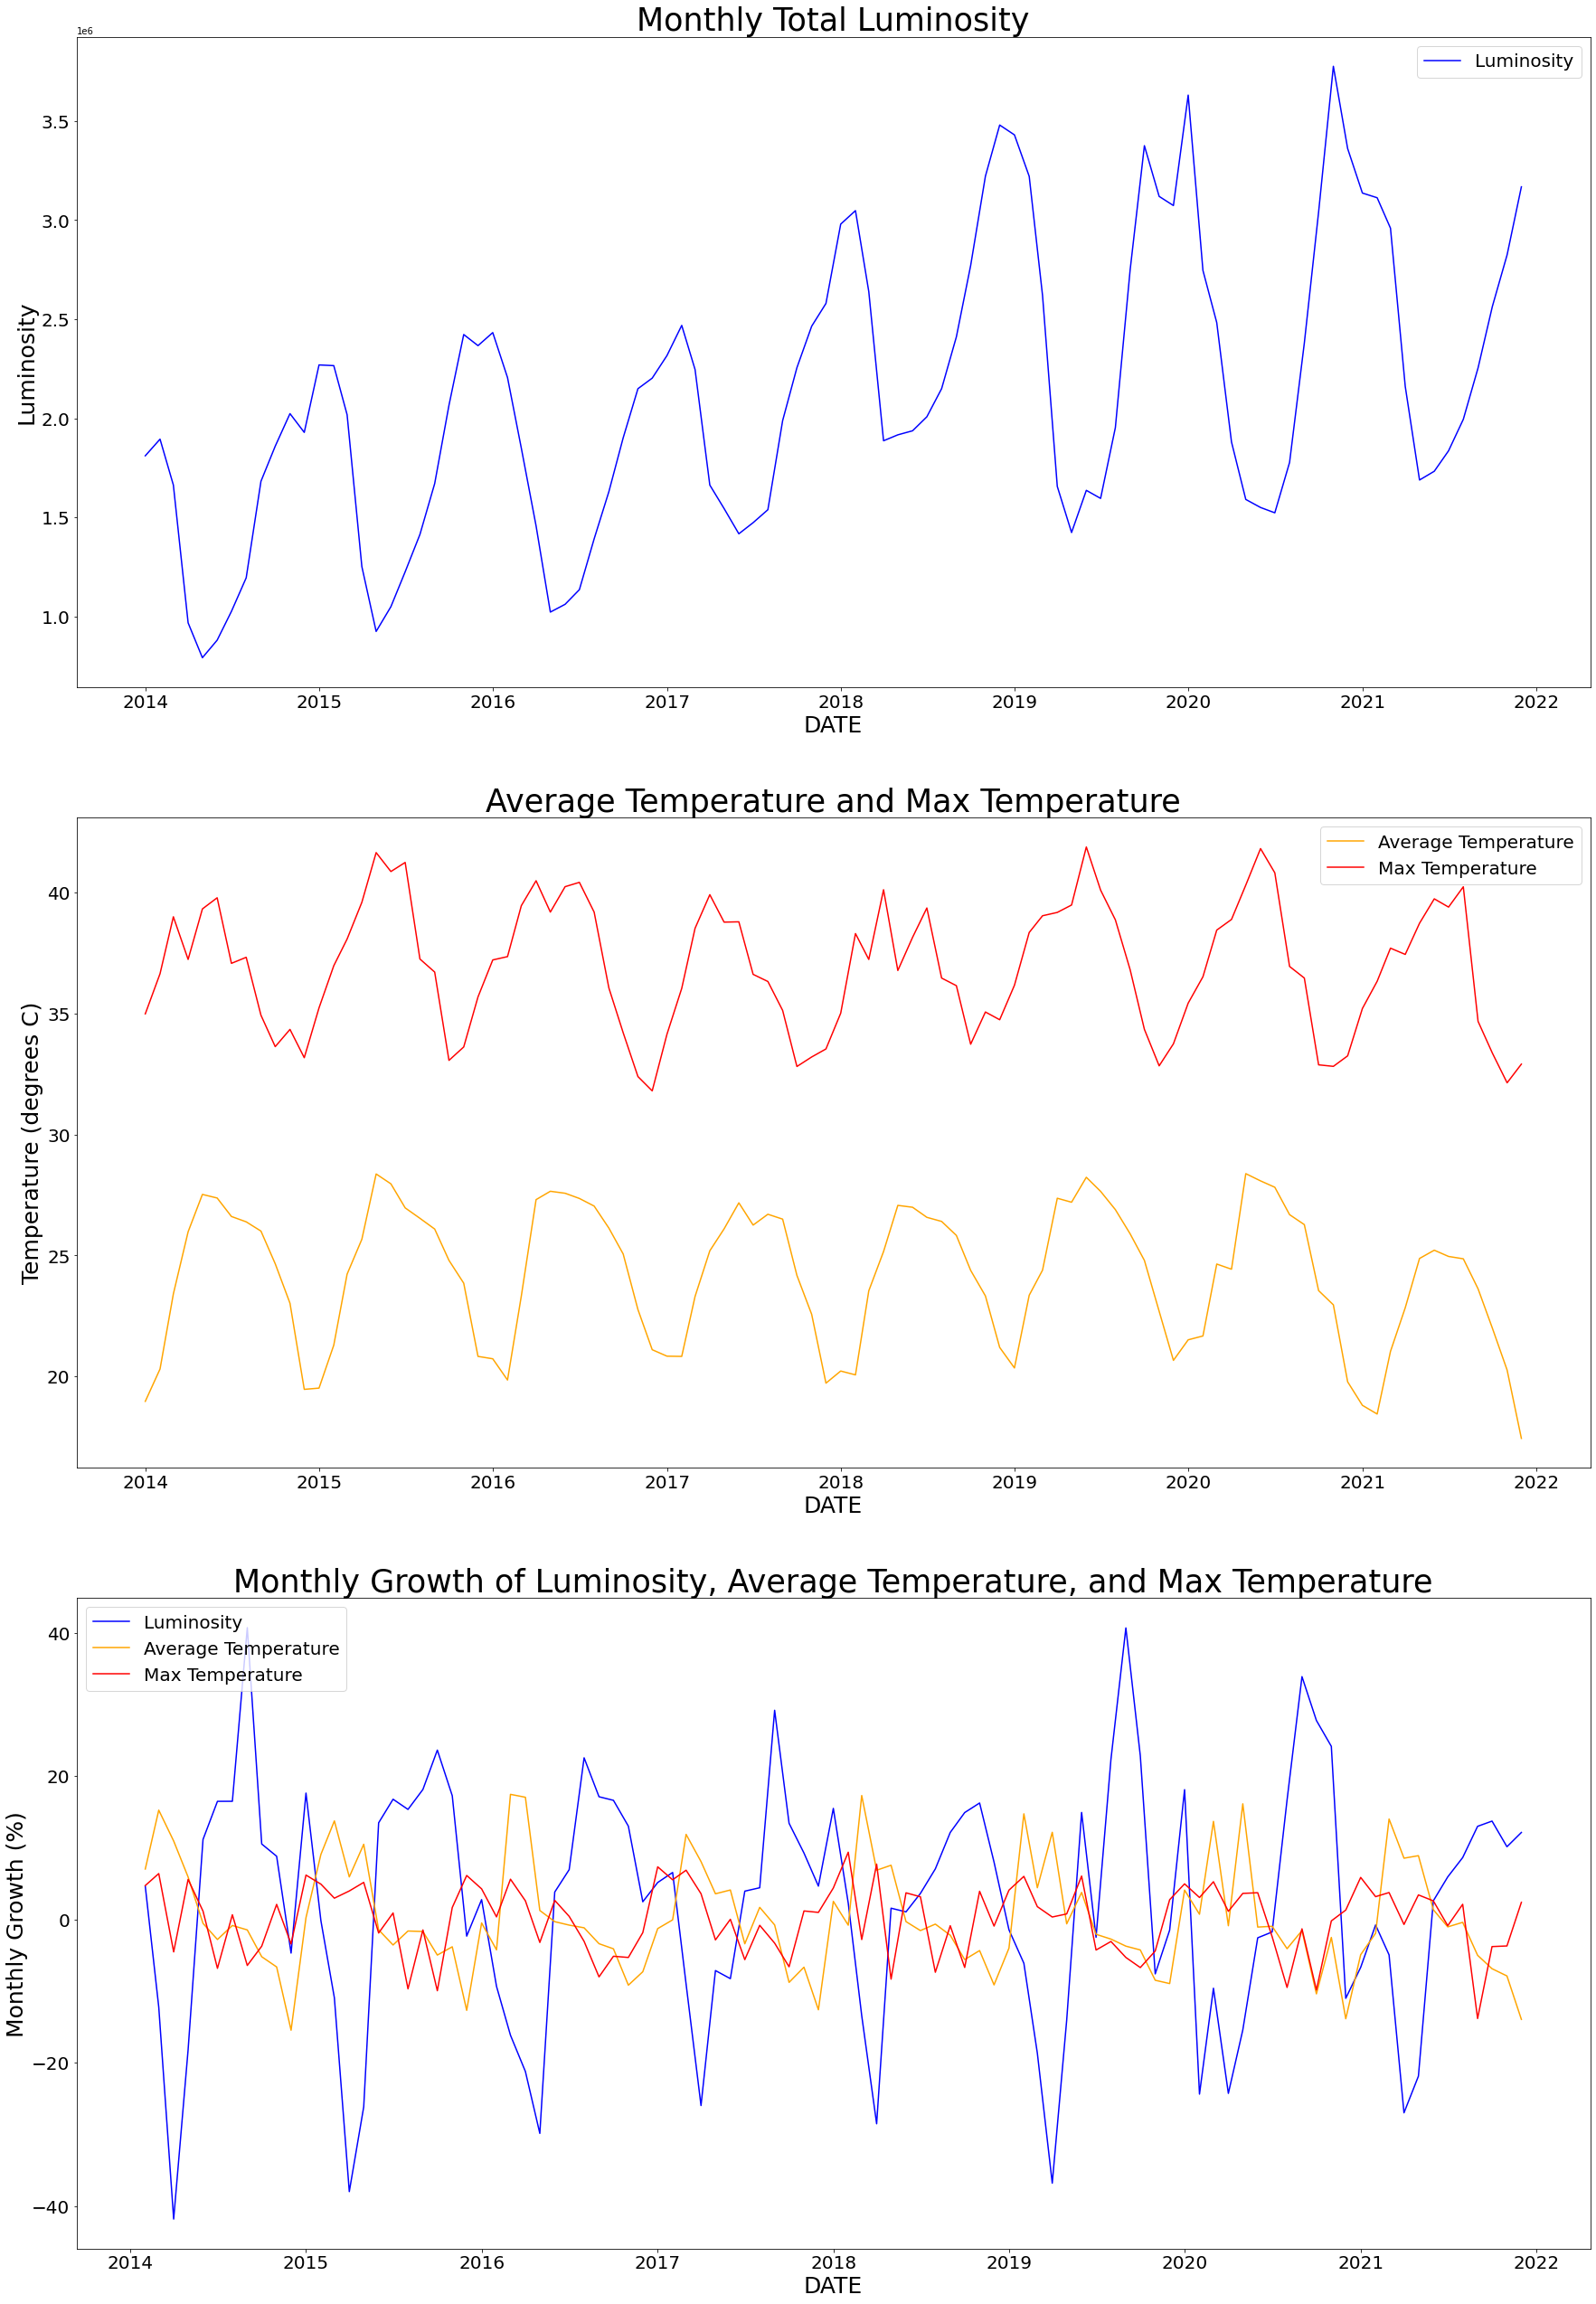

In [ ]:
df_gb['DATE'] = pd.to_datetime(df_gb.YEAR.astype(str)+' '+ df_gb.MONTH.astype(str))
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(30, 45))

# Plotting the monthly log luminosity 
ax0 = sns.lineplot(data=df_gb, x='DATE', y='LUMINOSITY_SUM', color='blue', label='Luminosity', ci=None, ax=axes[0])
ax0.set_xlabel('DATE', fontsize=25)
ax0.set_ylabel('Luminosity', fontsize=25)
ax0.set_title(f"Monthly Total Luminosity", 
                fontsize=35)
ax0.tick_params(axis='both', which='major', labelsize=20)
ax0.tick_params(axis='both', which='minor', labelsize=15)
ax0.legend(loc='best', fontsize=20)     

# Plotting the monthly log luminosity 
ax1 = sns.lineplot(data=df_gb, x='DATE', y='AVERAGE_TEMPERATURE', color='orange', label='Average Temperature', ci=None, ax=axes[1])
ax1 = sns.lineplot(data=df_gb, x='DATE', y='MAX_TEMPERATURE', color='red', label='Max Temperature', ci=None, ax=axes[1])
ax1.set_xlabel('DATE', fontsize=25)
ax1.set_ylabel('Temperature (degrees C)', fontsize=25)
ax1.set_title(f"Average Temperature and Max Temperature", 
                fontsize=35)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.legend(loc='best', fontsize=20)     

# Plotting the Montly Percentage Change in Luminosity
ax2 = sns.lineplot(data=df_gb, x='DATE', y='LUMINOSITY_PCT_CHANGE', color='blue', label='Luminosity', ci=None, ax=axes[2])
ax2 = sns.lineplot(data=df_gb, x='DATE', y='AVG_TEMP_PCT_CHANGE', color='orange', label='Average Temperature', ci=None, ax=axes[2])
ax2 = sns.lineplot(data=df_gb, x='DATE', y='MAX_TEMP_PCT_CHANGE', color='red', label='Max Temperature', ci=None, ax=axes[2])
ax2.set_xlabel('DATE', fontsize=25)
ax2.set_ylabel('Monthly Growth (%)', fontsize=25)
ax2.set_title(f"Monthly Growth of Luminosity, Average Temperature, and Max Temperature", 
                fontsize=35)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.legend(loc='upper left', fontsize=20)

plt.show()


## Regression

### Log Lumi - Nominal Temp Regression

In [ ]:
df_panel = df[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'YEAR_MONTH', 'LOG_LUMINOSITY_SUM', 'AVERAGE_TEMPERATURE']]
log_lumi_avg_temp_fixed_prov_ym = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LOG_LUMINOSITY_SUM'], 
                                                       Y_var='AVERAGE_TEMPERATURE',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])


df_panel = df[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'YEAR_MONTH', 'LOG_LUMINOSITY_SUM', 'MAX_TEMPERATURE']]
log_lumi_max_temp_fixed_prov_ym = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LOG_LUMINOSITY_SUM'], 
                                                       Y_var='MAX_TEMPERATURE',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

stargazer = Stargazer([log_lumi_avg_temp_fixed_prov_ym,
                       log_lumi_max_temp_fixed_prov_ym])
stargazer.render_latex()
# HTML(stargazer.render_html())

['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', '

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lcc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n\\\\[-1.8ex] & (1) & (2) \\\\\n\\hline \\\\[-1.8ex]\n Intercept & 12.802$^{***}$ & 23.776$^{***}$ \\\\\n  & (0.109) & (0.112) \\\\\n LOG_LUMINOSITY_SUM & 0.266$^{***}$ & 0.151$^{***}$ \\\\\n  & (0.006) & (0.006) \\\\\n Q("0") & 1.788$^{***}$ & 0.752$^{***}$ \\\\\n  & (0.109) & (0.112) \\\\\n Q("1") & 3.134$^{***}$ & 3.328$^{***}$ \\\\\n  & (0.109) & (0.112) \\\\\n Q("10") & 5.829$^{***}$ & 3.020$^{***}$ \\\\\n  & (0.109) & (0.112) \\\\\n Q("11") & 2.267$^{***}$ & -0.754$^{***}$ \\\\\n  & (0.109) & (0.112) \\\\\n Q("12") & 2.307$^{***}$ & 0.867$^{***}$ \\\\\n  & (0.109) & (0.112) \\\\\n Q("13") & 4.041$^{***}$ & 4.490$^{***}$ \\\\\n  & (0.109) & (0.112) \\\\\n Q("14") & 6.975$^{***}$ & 6.950$^{***}$ \\\\\n  & (0.109) & (0.112) \\\\\n Q("15") & 8.381$^{***}$ & 9.002$^{***}$ \\\\\n  & (0.109) & (0.112) \\\\\n Q("16") & 11.110$^{***}$ & 9.125$^{***}$ \\\\\n  & (0.109) 

### Percentage Change Regression

In [ ]:
df_panel = df_pct[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'YEAR_MONTH', 'LUMINOSITY_PCT_CHANGE', 'AVG_TEMP_PCT_CHANGE']]
lumi_avg_temp_pct_fixed_prov_ym = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LUMINOSITY_PCT_CHANGE'], 
                                                       Y_var='AVG_TEMP_PCT_CHANGE',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

df_panel = df_pct[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'YEAR_MONTH', 'LUMINOSITY_PCT_CHANGE', 'MAX_TEMP_PCT_CHANGE']]
lumi_max_temp_pct_fixed_prov_ym = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LUMINOSITY_PCT_CHANGE'], 
                                                       Y_var='MAX_TEMP_PCT_CHANGE',
                                                       effect_vars_list=['NAME_1', 'TIME_ENCODE'])

stargazer = Stargazer([lumi_avg_temp_pct_fixed_prov_ym,
                       lumi_max_temp_pct_fixed_prov_ym])

stargazer.render_latex()
# HTML(stargazer.render_html())

['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', '

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lcc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n\\\\[-1.8ex] & (1) & (2) \\\\\n\\hline \\\\[-1.8ex]\n Intercept & 0.851$^{***}$ & 0.899$^{***}$ \\\\\n  & (0.003) & (0.003) \\\\\n LUMINOSITY_PCT_CHANGE & 0.003$^{***}$ & 0.009$^{***}$ \\\\\n  & (0.001) & (0.001) \\\\\n Q("1") & 0.224$^{***}$ & 0.193$^{***}$ \\\\\n  & (0.003) & (0.003) \\\\\n Q("10") & 0.083$^{***}$ & 0.056$^{***}$ \\\\\n  & (0.003) & (0.003) \\\\\n Q("11") & -0.016$^{***}$ & -0.036$^{***}$ \\\\\n  & (0.003) & (0.003) \\\\\n Q("13") & 0.255$^{***}$ & 0.234$^{***}$ \\\\\n  & (0.003) & (0.003) \\\\\n Q("14") & 0.298$^{***}$ & 0.176$^{***}$ \\\\\n  & (0.003) & (0.003) \\\\\n Q("15") & 0.215$^{***}$ & 0.157$^{***}$ \\\\\n  & (0.003) & (0.003) \\\\\n Q("16") & 0.264$^{***}$ & 0.099$^{***}$ \\\\\n  & (0.003) & (0.003) \\\\\n Q("17") & 0.138$^{***}$ & 0.073$^{***}$ \\\\\n  & (0.003) & (0.003) \\\\\n Q("18") & 0.117$^{***}$ & 0.085$^{***}$ \\\\\n  & (0.003

### Urban / Rural

In [25]:
df = process_data(bm, avg_temp, max_temp, air, air_avg,
                  yearly=False, pop_zone=True)

df['TIME_ENCODE'] = df['YEAR_MONTH'].astype('category').cat.codes.astype(str)

df_pct = df[['GID_2',	'YEAR',	'MONTH', 'YEAR_MONTH', 'COUNTRY', 'NAME_1', 'NAME_2', 
             'GID_1', 'TIME_ENCODE', 'LUMINOSITY_PCT_CHANGE', 
             'AVG_TEMP_PCT_CHANGE', 'MAX_TEMP_PCT_CHANGE', 'POP_ZONE']]

df_pct = df_pct.dropna().reset_index(drop=True)

cleaning data

aggregating data

combining data

rest of steps


#### Lineplots

In [ ]:
merge_gb_cols = ['POP_ZONE', 'YEAR_MONTH']
df_gb = df.groupby(merge_gb_cols)\
          .agg(YEAR=('YEAR', 'first'),
               MONTH=('MONTH', 'first'),
               LUMINOSITY_SUM=('LUMINOSITY_SUM', 'sum'),
               AVERAGE_TEMPERATURE=('AVERAGE_TEMPERATURE', 'mean'),
               MAX_TEMPERATURE=('MAX_TEMPERATURE', 'max'))\
          .reset_index()
# df_gb = df_gb[df_gb['YEAR'].between(2014, 2021)]

gb_cols = ['POP_ZONE']
df_gb['LUMINOSITY_PCT_CHANGE'] = \
                100*(df_gb.groupby(gb_cols)['LUMINOSITY_SUM'].apply(pd.Series.pct_change))
df_gb['AVG_TEMP_PCT_CHANGE'] = \
                100*(df_gb.groupby(gb_cols)['AVERAGE_TEMPERATURE'].apply(pd.Series.pct_change))
df_gb['MAX_TEMP_PCT_CHANGE'] = \
                100*(df_gb.groupby(gb_cols)['MAX_TEMPERATURE'].apply(pd.Series.pct_change))

df_gb

,POP_ZONE,YEAR_MONTH,YEAR,MONTH,LUMINOSITY_SUM,AVERAGE_TEMPERATURE,MAX_TEMPERATURE,LUMINOSITY_PCT_CHANGE,AVG_TEMP_PCT_CHANGE,MAX_TEMP_PCT_CHANGE
0,rural,201401,2014,1,6.202626e+05,18.764993,34.932175,NaN,NaN,NaN
1,rural,201402,2014,2,6.826308e+05,20.149090,36.640541,10.055124,7.375951,4.890524
2,rural,201403,2014,3,6.180977e+05,23.274491,38.991463,-9.453583,15.511378,6.416176
3,rural,201404,2014,4,2.666452e+05,25.830575,37.229744,-56.860346,10.982340,-4.518217
4,rural,201405,2014,5,1.440323e+05,27.365840,39.315392,-45.983538,5.943597,5.602100
...,...,...,...,...,...,...,...,...,...,...
187,urban,202108,2021,8,1.366950e+06,24.986538,40.229767,2.940107,-0.373336,2.832027
188,urban,202109,2021,9,1.484133e+06,23.740820,34.671047,8.572646,-4.985556,-13.817429
189,urban,202110,2021,10,1.637435e+06,22.118502,33.362854,10.329348,-6.833454,-3.773157
190,urban,202111,2021,11,1.753986e+06,20.391111,32.133133,7.117923,-7.809712,-3.685899


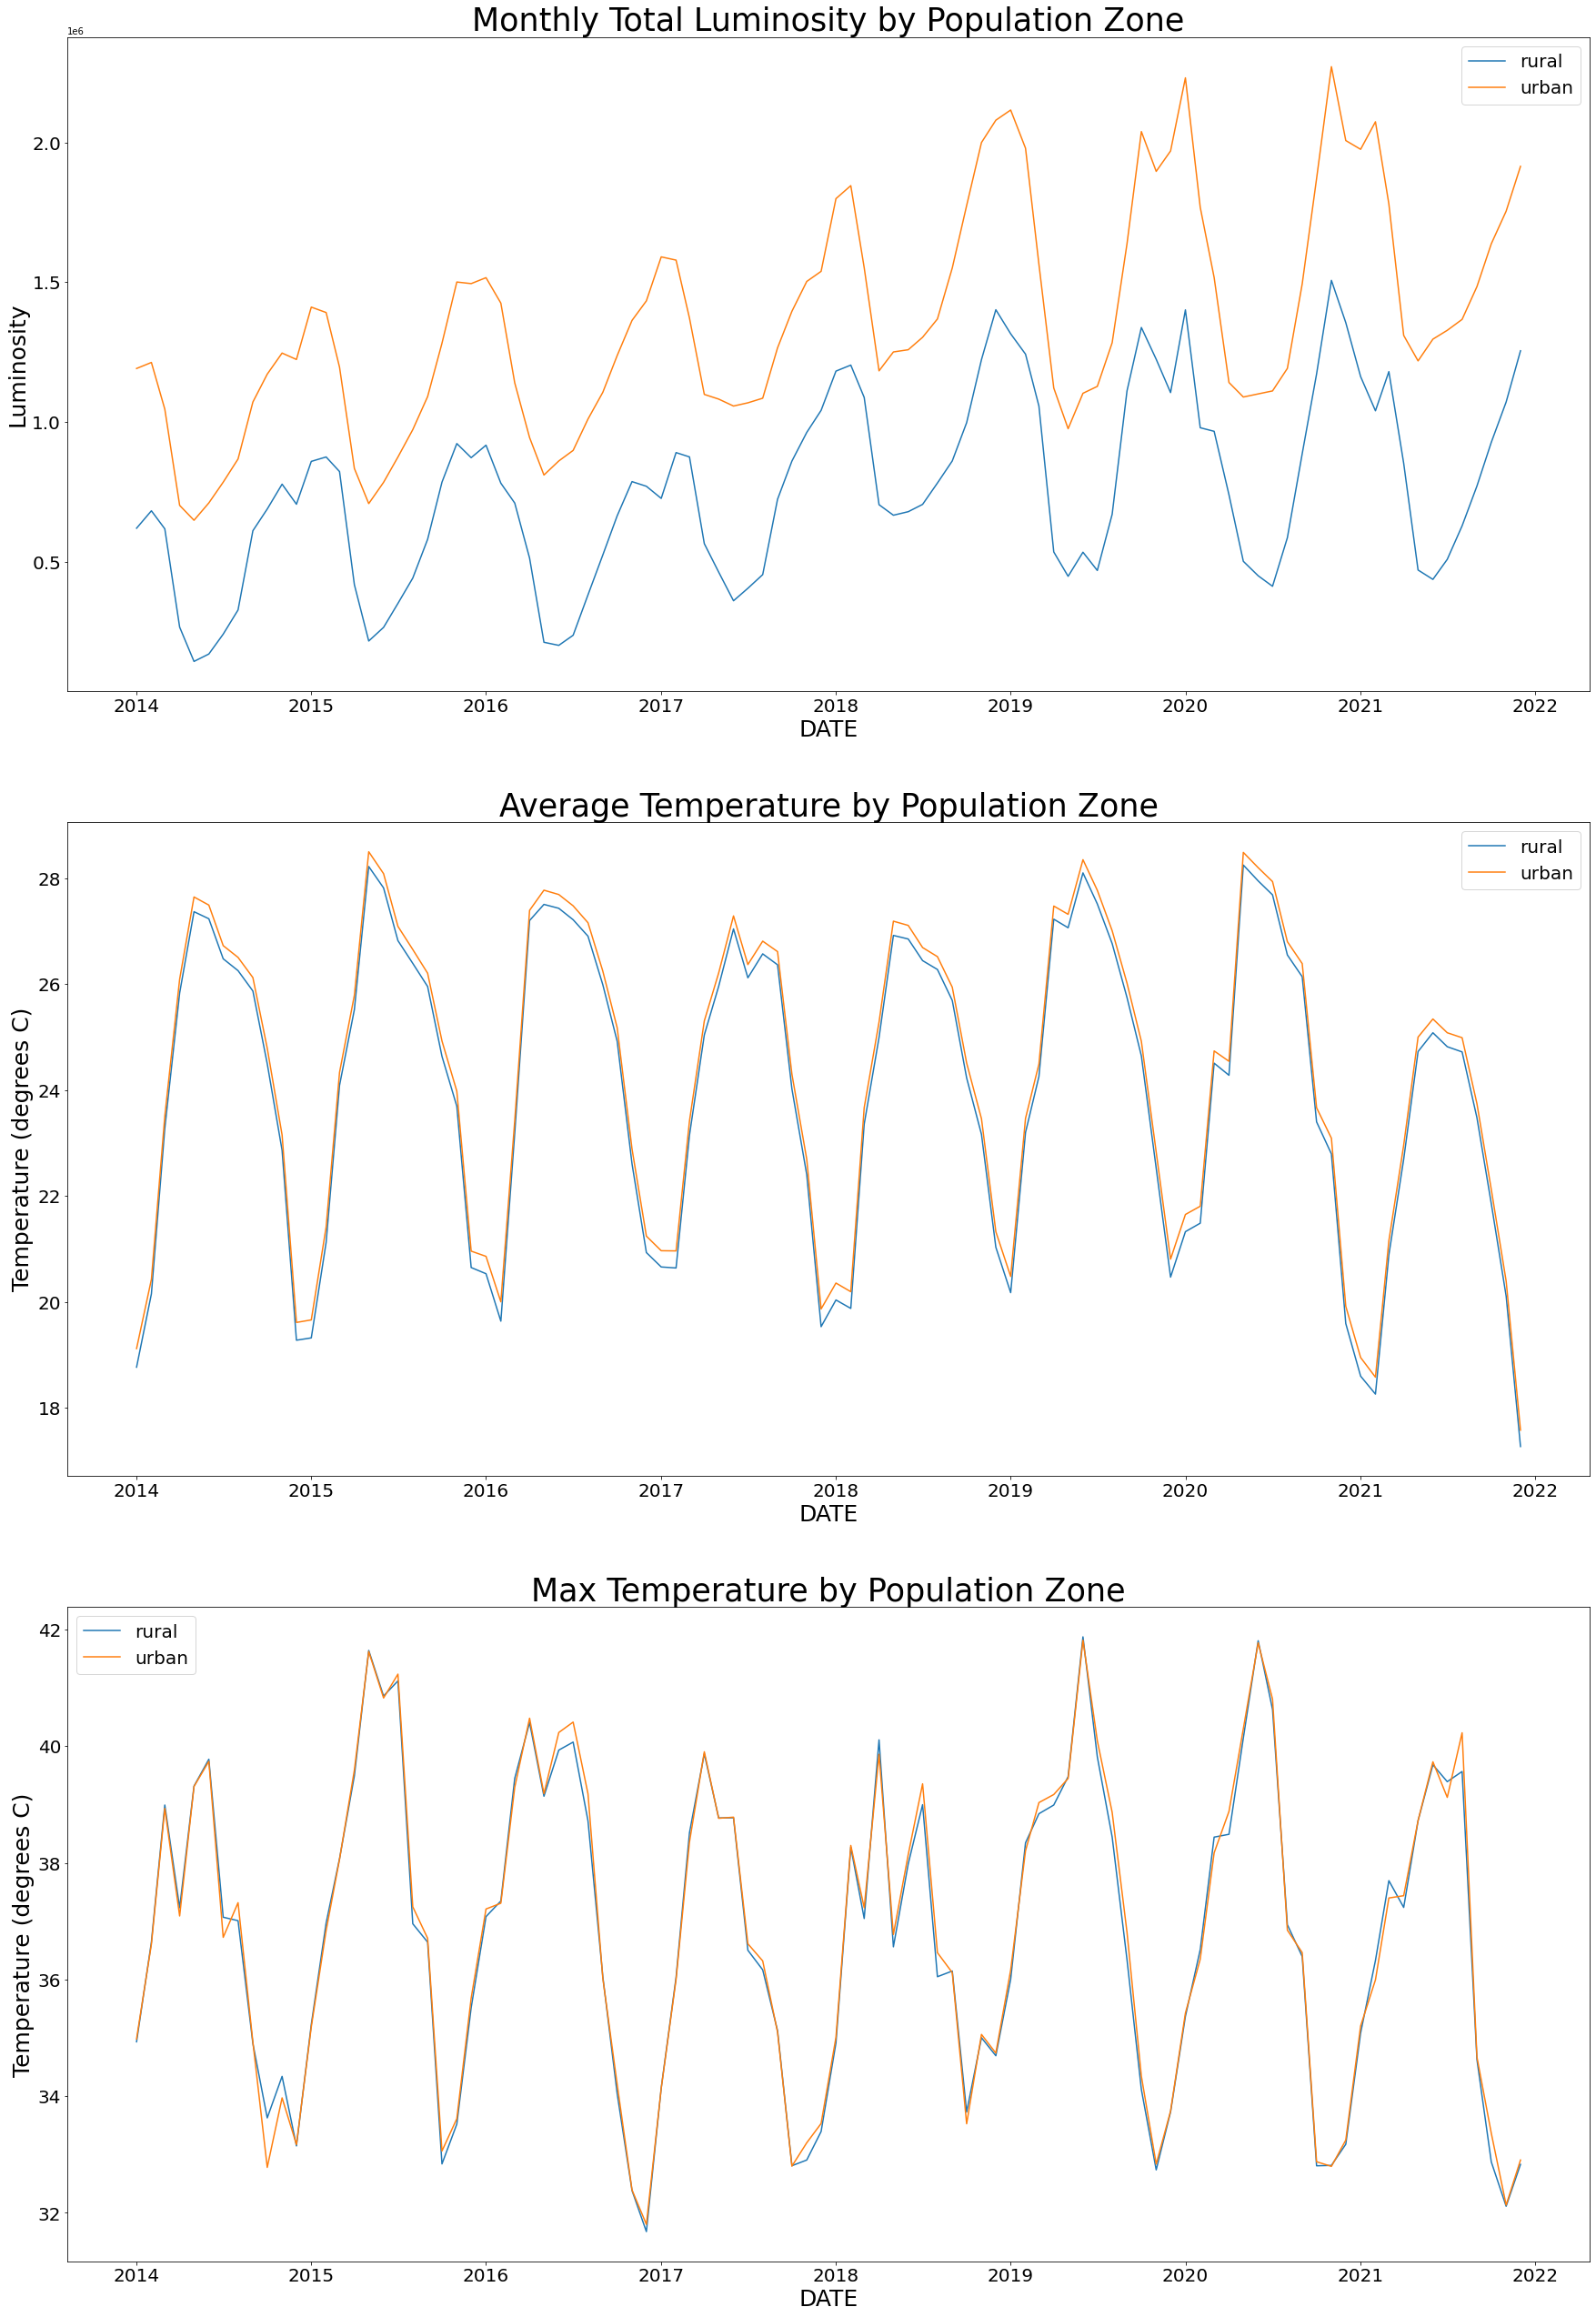

In [ ]:
df_gb['DATE'] = pd.to_datetime(df_gb.YEAR.astype(str)+' '+ df_gb.MONTH.astype(str))
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(30, 45))

# Plotting the monthly log luminosity 
ax0 = sns.lineplot(data=df_gb, x='DATE', y='LUMINOSITY_SUM', hue='POP_ZONE',
                   color='blue', ci=None, ax=axes[0])
ax0.set_xlabel('DATE', fontsize=25)
ax0.set_ylabel('Luminosity', fontsize=25)
ax0.set_title(f"Monthly Total Luminosity by Population Zone", 
              fontsize=35)
ax0.tick_params(axis='both', which='major', labelsize=20)
ax0.tick_params(axis='both', which='minor', labelsize=15)
ax0.legend(loc='best', fontsize=20) 

# Plotting the monthly log luminosity 
ax1 = sns.lineplot(data=df_gb, x='DATE', y='AVERAGE_TEMPERATURE', hue='POP_ZONE',
                   color='orange', ci=None, ax=axes[1])
ax1.set_xlabel('DATE', fontsize=25)
ax1.set_ylabel('Temperature (degrees C)', fontsize=25)
ax1.set_title(f"Average Temperature by Population Zone", 
              fontsize=35)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.legend(loc='best', fontsize=20)     

# Plotting the Montly Percentage Change in Luminosity
ax2 = sns.lineplot(data=df_gb, x='DATE', y='MAX_TEMPERATURE', hue='POP_ZONE',
                   color='blue', ci=None, ax=axes[2])
ax2.set_xlabel('DATE', fontsize=25)
ax2.set_ylabel('Temperature (degrees C)', fontsize=25)
ax2.set_title(f"Max Temperature by Population Zone", 
              fontsize=35)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.legend(loc='upper left', fontsize=20)

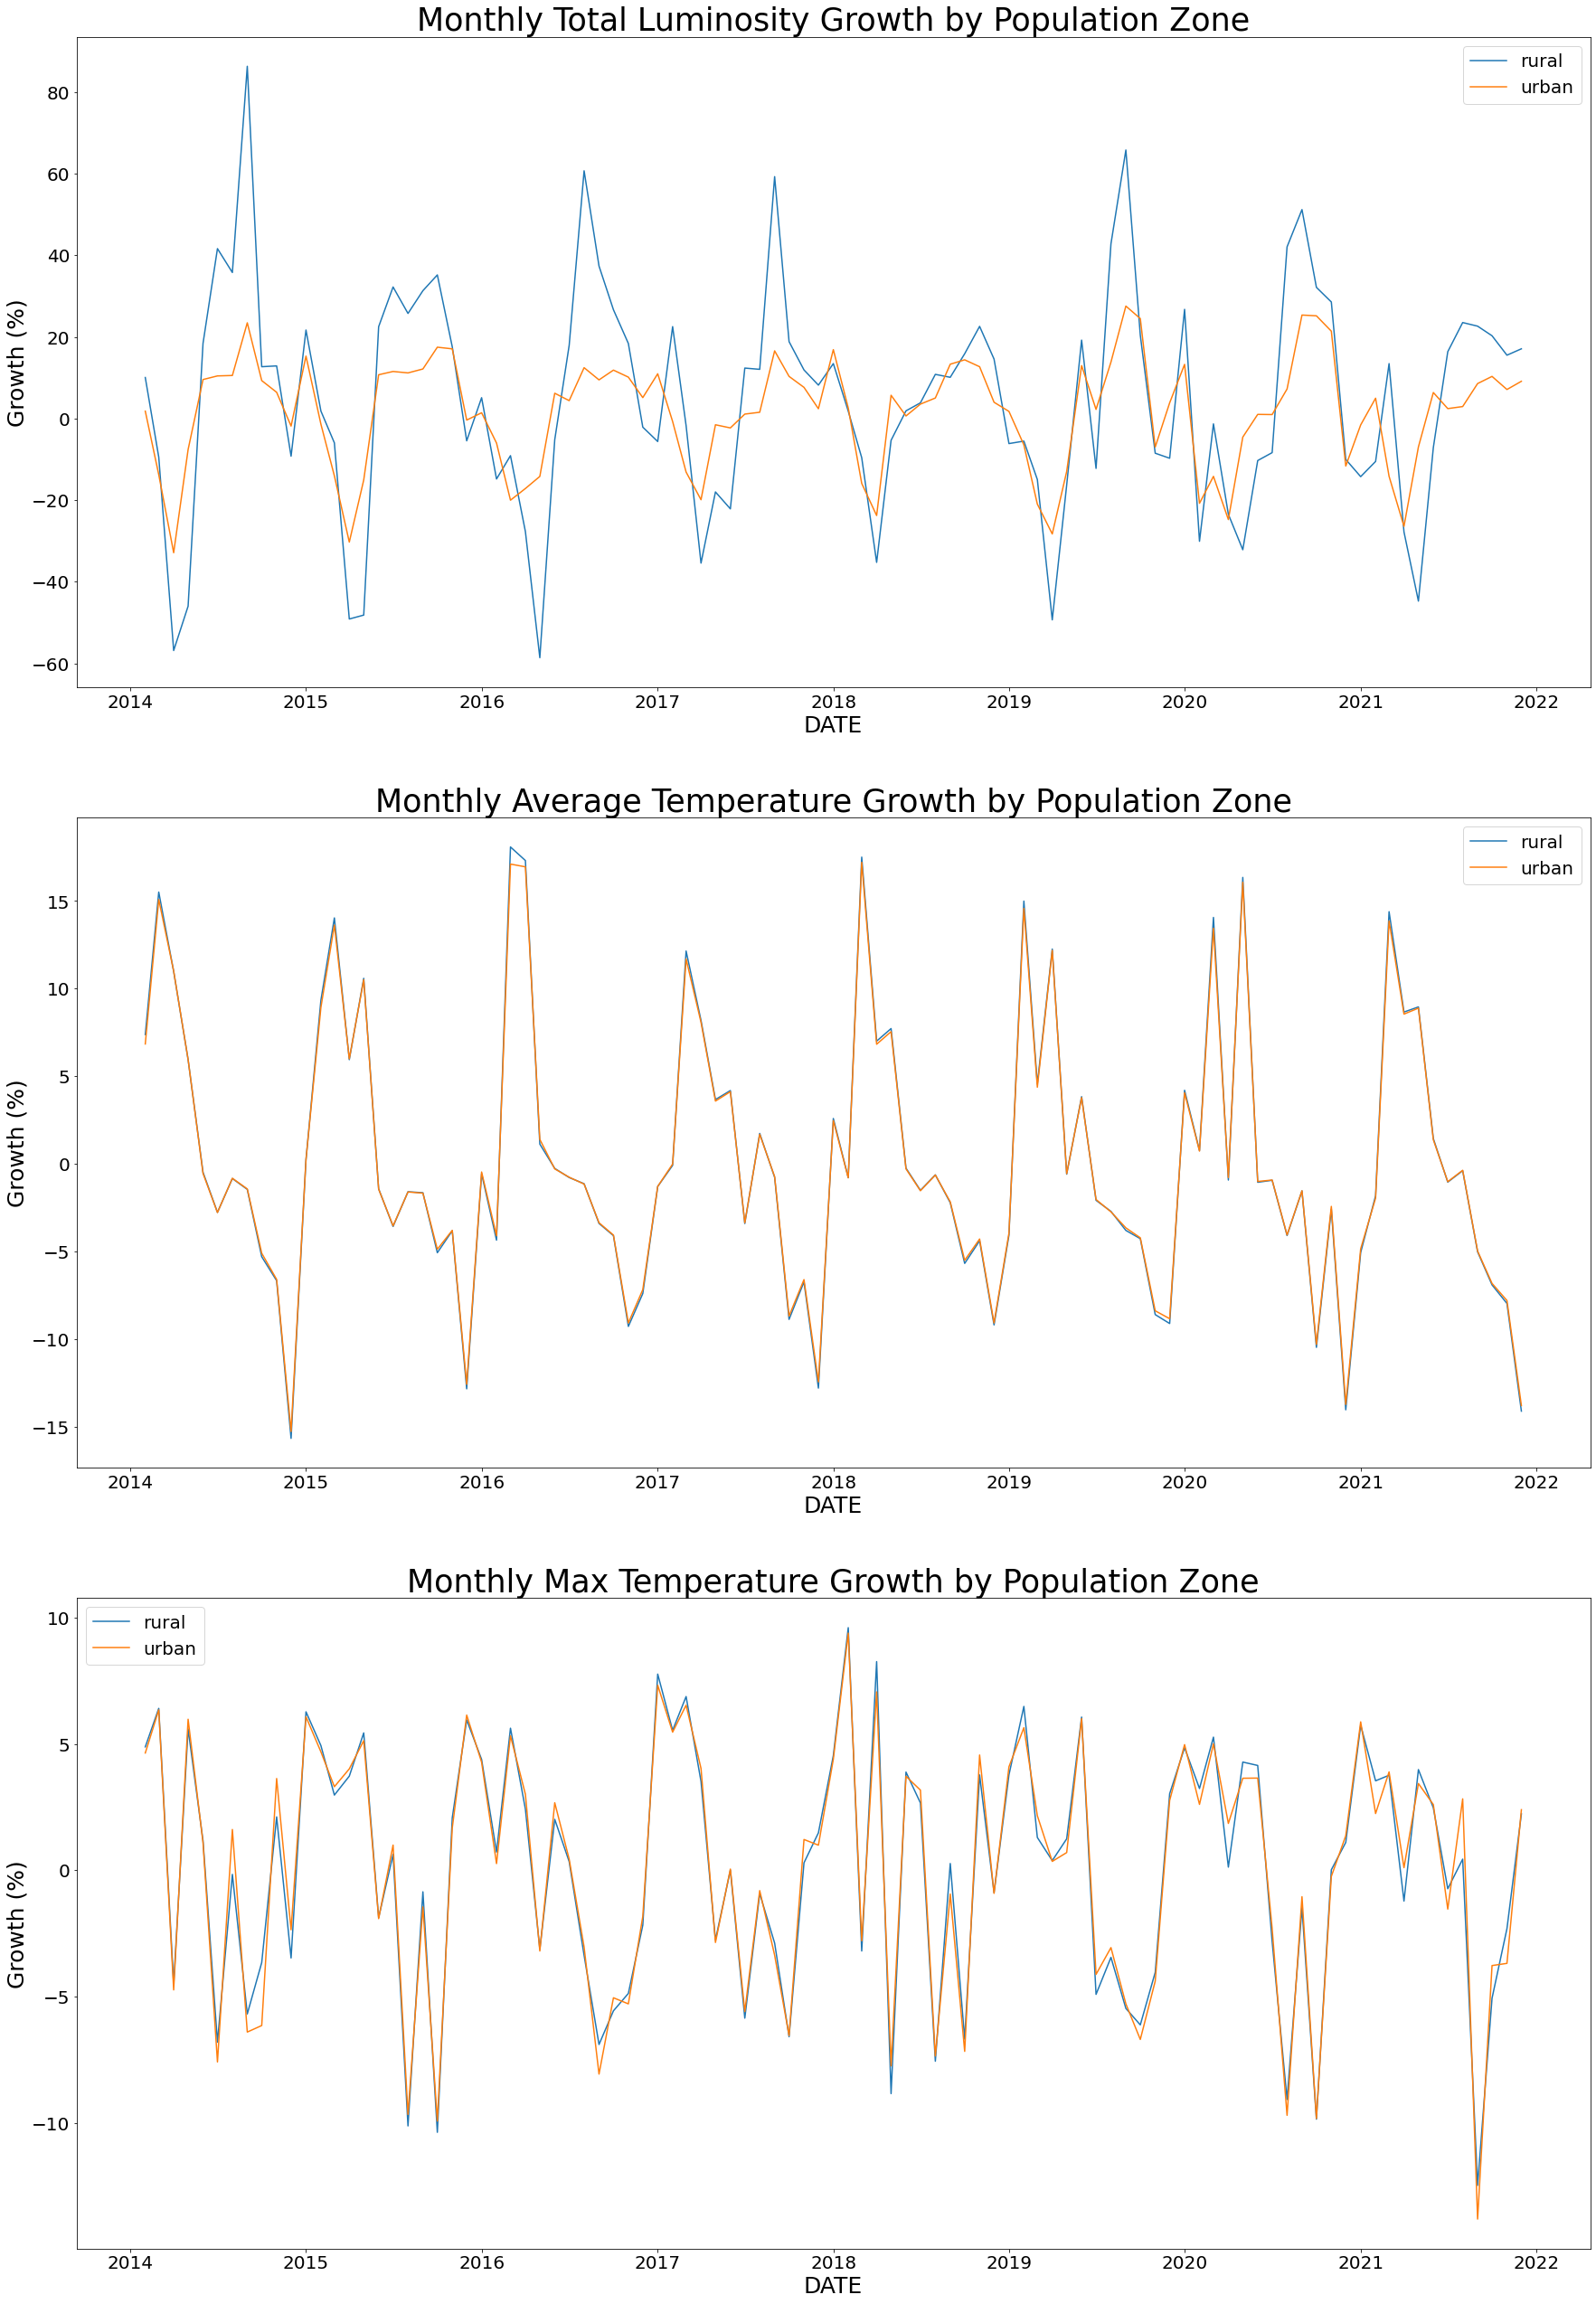

In [ ]:
# df['DATE'] = pd.to_datetime(df.YEAR.astype(str)+' '+ df.MONTH.astype(str))
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(30, 45))

# Plotting the annual luminosity 
ax0 = sns.lineplot(data=df_gb, x='DATE', y='LUMINOSITY_PCT_CHANGE', hue='POP_ZONE',
                   color='blue', ci=None, ax=axes[0])
ax0.set_xlabel('DATE', fontsize=25)
ax0.set_ylabel('Growth (%)', fontsize=25)
ax0.set_title(f"Monthly Total Luminosity Growth by Population Zone", 
              fontsize=35)
ax0.tick_params(axis='both', which='major', labelsize=20)
ax0.tick_params(axis='both', which='minor', labelsize=15)
ax0.legend(loc='best', fontsize=20) 

# Plotting the annual average temperature
ax1 = sns.lineplot(data=df_gb, x='DATE', y='AVG_TEMP_PCT_CHANGE', hue='POP_ZONE',
                   color='orange', ci=None, ax=axes[1])
ax1.set_xlabel('DATE', fontsize=25)
ax1.set_ylabel('Growth (%)', fontsize=25)
ax1.set_title(f"Monthly Average Temperature Growth by Population Zone", 
              fontsize=35)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.legend(loc='best', fontsize=20)     

# Plotting the annual max temperature 
ax2 = sns.lineplot(data=df_gb, x='DATE', y='MAX_TEMP_PCT_CHANGE', hue='POP_ZONE',
                   color='blue', ci=None, ax=axes[2])
ax2.set_xlabel('DATE', fontsize=25)
ax2.set_ylabel('Growth (%)', fontsize=25)
ax2.set_title(f"Monthly Max Temperature Growth by Population Zone", 
              fontsize=35)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.legend(loc='upper left', fontsize=20)


#### Overall Regressions

In [26]:
df_panel = df[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'YEAR_MONTH', 'POP_ZONE','LOG_LUMINOSITY_SUM', 'AVERAGE_TEMPERATURE']]
log_lumi_avg_temp_fixed_prov_ym = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LOG_LUMINOSITY_SUM'], 
                                                       Y_var='AVERAGE_TEMPERATURE',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1', 'TIME_ENCODE'])


df_panel = df[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'YEAR_MONTH', 'POP_ZONE','LOG_LUMINOSITY_SUM', 'MAX_TEMPERATURE']]
log_lumi_max_temp_fixed_prov_ym = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LOG_LUMINOSITY_SUM'], 
                                                       Y_var='MAX_TEMPERATURE',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1', 'TIME_ENCODE'])

stargazer = Stargazer([log_lumi_avg_temp_fixed_prov_ym,
                       log_lumi_max_temp_fixed_prov_ym])
stargazer.render_latex()
# HTML(stargazer.render_html())

['rural', 'urban']
['rural']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lcc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n\\\\[-1.8ex] & (1) & (2) \\\\\n\\hline \\\\[-1.8ex]\n Intercept & 13.531$^{***}$ & 24.135$^{***}$ \\\\\n  & (0.078) & (0.079) \\\\\n LOG_LUMINOSITY_SUM & 0.153$^{***}$ & 0.070$^{***}$ \\\\\n  & (0.004) & (0.004) \\\\\n Q("0") & 1.685$^{***}$ & 0.654$^{***}$ \\\\\n  & (0.079) & (0.080) \\\\\n Q("1") & 3.033$^{***}$ & 3.220$^{***}$ \\\\\n  & (0.079) & (0.080) \\\\\n Q("10") & 5.739$^{***}$ & 2.958$^{***}$ \\\\\n  & (0.079) & (0.080) \\\\\n Q("11") & 2.175$^{***}$ & -0.823$^{***}$ \\\\\n  & (0.079) & (0.080) \\\\\n Q("12") & 2.212$^{***}$ & 0.772$^{***}$ \\\\\n  & (0.079) & (0.080) \\\\\n Q("13") & 3.965$^{***}$ & 4.405$^{***}$ \\\\\n  & (0.079) & (0.080) \\\\\n Q("14") & 6.900$^{***}$ & 6.864$^{***}$ \\\\\n  & (0.079) & (0.080) \\\\\n Q("15") & 8.322$^{***}$ & 8.927$^{***}$ \\\\\n  & (0.079) & (0.080) \\\\\n Q("16") & 11.051$^{***}$ & 9.052$^{***}$ \\\\\n  & (0.079) 

In [27]:
df_panel = df_pct[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'LUMINOSITY_PCT_CHANGE', 
                   'AVG_TEMP_PCT_CHANGE', 'MAX_TEMP_PCT_CHANGE', 'POP_ZONE']]
lumi_avg_temp_pct_fixed_ym = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LUMINOSITY_PCT_CHANGE'], 
                                                       Y_var='AVG_TEMP_PCT_CHANGE',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1', 'TIME_ENCODE'])

# df_panel = df_pct[['NAME_2', 'TIME_ENCODE', 'LUMINOSITY_PCT_CHANGE', 'MAX_TEMP_PCT_CHANGE']]
lumi_max_temp_pct_fixed_ym = reg_panelols_fixedeffects(df_panel=df_panel,
                                                       X_vars=['LUMINOSITY_PCT_CHANGE'], 
                                                       Y_var='MAX_TEMP_PCT_CHANGE',
                                                       effect_vars_list=['POP_ZONE', 'NAME_1', 'TIME_ENCODE'])

stargazer = Stargazer([lumi_avg_temp_pct_fixed_ym,
                       lumi_max_temp_pct_fixed_ym])

stargazer.render_latex()
# HTML(stargazer.render_html())

['rural', 'urban']
['rural']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lcc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n\\\\[-1.8ex] & (1) & (2) \\\\\n\\hline \\\\[-1.8ex]\n Intercept & 0.852$^{***}$ & 0.901$^{***}$ \\\\\n  & (0.002) & (0.002) \\\\\n LUMINOSITY_PCT_CHANGE & 0.002$^{***}$ & 0.007$^{***}$ \\\\\n  & (0.000) & (0.000) \\\\\n Q("1") & 0.225$^{***}$ & 0.194$^{***}$ \\\\\n  & (0.002) & (0.002) \\\\\n Q("10") & 0.084$^{***}$ & 0.057$^{***}$ \\\\\n  & (0.002) & (0.002) \\\\\n Q("11") & -0.016$^{***}$ & -0.036$^{***}$ \\\\\n  & (0.002) & (0.002) \\\\\n Q("13") & 0.256$^{***}$ & 0.236$^{***}$ \\\\\n  & (0.002) & (0.002) \\\\\n Q("14") & 0.299$^{***}$ & 0.176$^{***}$ \\\\\n  & (0.002) & (0.002) \\\\\n Q("15") & 0.216$^{***}$ & 0.158$^{***}$ \\\\\n  & (0.002) & (0.002) \\\\\n Q("16") & 0.265$^{***}$ & 0.100$^{***}$ \\\\\n  & (0.002) & (0.002) \\\\\n Q("17") & 0.138$^{***}$ & 0.073$^{***}$ \\\\\n  & (0.002) & (0.002) \\\\\n Q("18") & 0.117$^{***}$ & 0.087$^{***}$ \\\\\n  & (0.002

## Air pollution (Nitrogen Dioxide)

In [16]:
df = process_data(bm, avg_temp, max_temp, air, air_avg,
                  yearly=False, pop_zone=False)

df['TIME_ENCODE'] = df['YEAR_MONTH'].astype('category').cat.codes.astype(str)

df_pct = df[['GID_2',	'YEAR',	'MONTH', 'YEAR_MONTH', 'COUNTRY', 'NAME_1', 'NAME_2', 'GID_1', 'TIME_ENCODE', 'LUMINOSITY_PCT_CHANGE', 
             'AVG_TEMP_PCT_CHANGE', 'MAX_TEMP_PCT_CHANGE']]

df_pct = df_pct.dropna().reset_index(drop=True)

cleaning data

aggregating data

combining data

rest of steps


In [17]:
no2 = no2[no2['id_reg'].str.contains('VNM')].reset_index(drop=True)
no2.columns = no2.columns.str.upper()
no2 = no2[['YEAR', 'MONTH', 'ID_REG', 'MEAN', 'AREA','VALID_DATA_RATIO']]

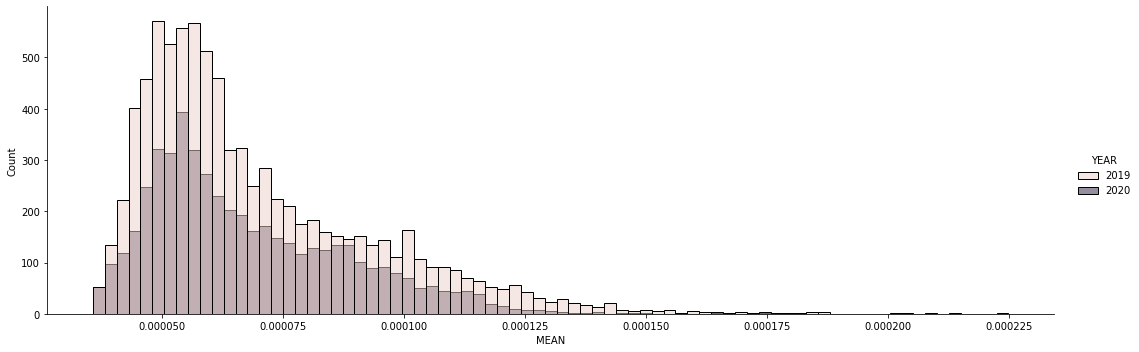

In [18]:
sns.displot(no2, x='MEAN', hue='YEAR', height=5, aspect=3, facet_kws=None)

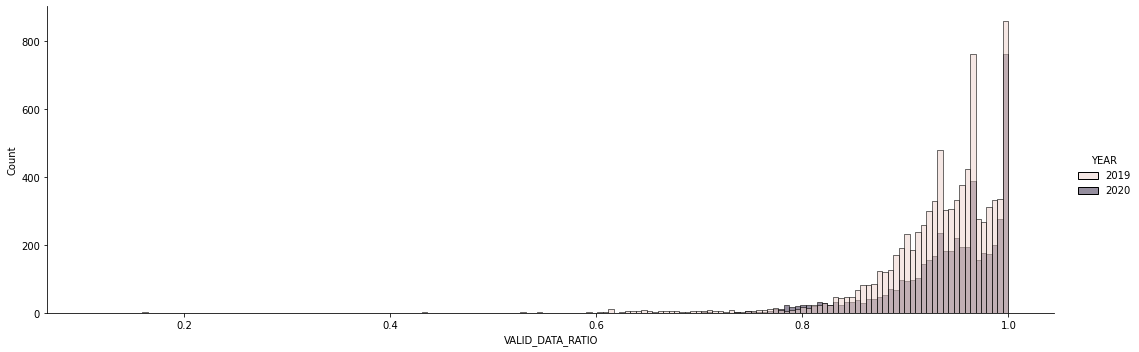

In [19]:
sns.displot(no2, x='VALID_DATA_RATIO', hue='YEAR', height=5, aspect=3, facet_kws=None)

In [20]:
no2 = no2.rename({'ID_REG': 'GID_2', 'MEAN': 'NO2_AVERAGE'}, axis=1)

In [21]:
df_no2 = pd.merge(no2, df, on=['GID_2', 'YEAR', 'MONTH'], how='left')

In [22]:
df_no2['NO2_AVERAGE_MASS'] = df_no2['NO2_AVERAGE'] * 46.01 * 1000
df_no2['NO2_AVG_PCT_CHANGE'] = 100*df_no2['NO2_AVERAGE_MASS'].pct_change(periods=1) 

In [13]:
df_no2

,YEAR,MONTH,GID_2,NO2_AVERAGE,AREA,VALID_DATA_RATIO,COUNTRY,GID_1,NAME_1,NAME_2,...,MAX_TEMPERATURE,LOG_LUMINOSITY_SUM,LUMINOSITY_PCT_CHANGE,AVG_TEMP_PCT_CHANGE,MAX_TEMP_PCT_CHANGE,DATE,YEAR_MONTH,TIME_ENCODE,NO2_AVERAGE_MASS,NO2_AVG_PCT_CHANGE
0,2019,1,VNM.1.10_1,0.000057,468.906,0.902645,Vietnam,VNM.1_1,An Giang,Tho?i S?n,...,31.920925,5.986708,NaN,NaN,NaN,2019-01-01,201901,60,2.617969,NaN
1,2019,2,VNM.1.10_1,0.000061,468.906,0.993573,Vietnam,VNM.1_1,An Giang,Tho?i S?n,...,33.962090,6.223070,1.266633,1.058058,1.063944,2019-02-01,201902,61,2.825014,7.908612
2,2019,3,VNM.1.10_1,0.000076,468.906,0.989303,Vietnam,VNM.1_1,An Giang,Tho?i S?n,...,35.839970,6.400264,1.193864,1.051499,1.055293,2019-03-01,201903,62,3.515164,24.429967
3,2019,4,VNM.1.10_1,0.000061,468.906,0.924764,Vietnam,VNM.1_1,An Giang,Tho?i S?n,...,36.648098,6.176611,0.799592,1.035546,1.022548,2019-04-01,201904,63,2.825014,-19.633508
4,2019,5,VNM.1.10_1,0.000056,468.906,0.917655,Vietnam,VNM.1_1,An Giang,Tho?i S?n,...,35.824253,6.340042,1.177544,0.960121,0.977520,2019-05-01,201905,64,2.571959,-8.957655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13485,2020,3,VNM.9.9_1,0.000084,83.566,0.998618,Vietnam,VNM.9_1,Bình D??ng,Thu?n An,...,35.155334,9.003358,0.937311,1.046694,1.022581,2020-03-01,202003,74,3.878643,-1.862631
13486,2020,4,VNM.9.9_1,0.000087,83.566,0.966667,Vietnam,VNM.9_1,Bình D??ng,Thu?n An,...,35.942375,8.974703,0.971751,1.001899,1.022388,2020-04-01,202004,75,3.979865,2.609727
13487,2020,5,VNM.9.9_1,0.000094,83.566,1.000000,Vietnam,VNM.9_1,Bình D??ng,Thu?n An,...,35.668186,8.951573,0.977136,1.031399,0.992371,2020-05-01,202005,76,4.315738,8.439306
13488,2020,6,VNM.9.9_1,0.000088,83.566,0.795918,Vietnam,VNM.9_1,Bình D??ng,Thu?n An,...,32.957306,8.989913,1.039084,0.914889,0.923997,2020-06-01,202006,77,4.062683,-5.863539


In [23]:
df_panel = df_no2[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'YEAR_MONTH', 'LOG_LUMINOSITY_SUM', 'NO2_AVERAGE_MASS']]
log_lumi_avg_no2_fixed_prov_ym = reg_panelols_fixedeffects(df_panel=df_panel,
                                                           X_vars=['LOG_LUMINOSITY_SUM'], 
                                                           Y_var='NO2_AVERAGE_MASS',
                                                           effect_vars_list=['NAME_1', 'TIME_ENCODE'])

stargazer = Stargazer([log_lumi_avg_no2_fixed_prov_ym])
stargazer.render_latex()
# HTML(stargazer.render_html())

['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', '

'\\begin{table}[!htbp] \\centering\n\\begin{tabular}{@{\\extracolsep{5pt}}lc}\n\\\\[-1.8ex]\\hline\n\\hline \\\\[-1.8ex]\n& \\multicolumn{1}{c}{\\textit{Dependent variable:}} \\\n\\cr \\cline{1-2}\n\\\\[-1.8ex] & (1) \\\\\n\\hline \\\\[-1.8ex]\n Intercept & 2.478$^{***}$ \\\\\n  & (0.045) \\\\\n LOG_LUMINOSITY_SUM & 0.092$^{***}$ \\\\\n  & (0.003) \\\\\n Q("60") & 0.095$^{***}$ \\\\\n  & (0.026) \\\\\n Q("61") & -0.025$^{}$ \\\\\n  & (0.026) \\\\\n Q("62") & 0.544$^{***}$ \\\\\n  & (0.026) \\\\\n Q("63") & 0.485$^{***}$ \\\\\n  & (0.026) \\\\\n Q("64") & 0.811$^{***}$ \\\\\n  & (0.026) \\\\\n Q("65") & 0.486$^{***}$ \\\\\n  & (0.026) \\\\\n Q("66") & 0.133$^{***}$ \\\\\n  & (0.026) \\\\\n Q("67") & 0.061$^{**}$ \\\\\n  & (0.026) \\\\\n Q("68") & -0.049$^{*}$ \\\\\n  & (0.026) \\\\\n Q("69") & 0.042$^{}$ \\\\\n  & (0.026) \\\\\n Q("70") & 0.066$^{**}$ \\\\\n  & (0.026) \\\\\n Q("71") & 0.257$^{***}$ \\\\\n  & (0.026) \\\\\n Q("72") & 0.017$^{}$ \\\\\n  & (0.026) \\\\\n Q("73") & -0.029$

In [53]:
df_panel = df_no2[['NAME_2', 'NAME_1', 'TIME_ENCODE', 'YEAR_MONTH', 
                    'LUMINOSITY_PCT_CHANGE', 'NO2_AVG_PCT_CHANGE']]
pct_lumi_avg_no2_fixed_prov_ym = reg_panelols_fixedeffects(df_panel=df_panel,
                                                           X_vars=['LUMINOSITY_PCT_CHANGE'], 
                                                           Y_var='NO2_AVG_PCT_CHANGE',
                                                           effect_vars_list=['NAME_1', 'TIME_ENCODE'])

stargazer = Stargazer([pct_lumi_avg_no2_fixed_prov_ym])
# stargazer.render_latex()
HTML(stargazer.render_html())

['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', 'Bình Thu?n', 'C?n Th?', 'Cao B?ng', 'Cà Mau', 'Gia Lai', 'H? Chí Minh', 'H?i D??ng', 'H?i Phòng', 'H?ng Yên', 'H?u Giang', 'Hoà Bình', 'Hà Giang', 'Hà N?i', 'Hà Nam', 'Hà T?nh', 'Khánh Hòa', 'Kiên Giang', 'Kon Tum', 'L?ng S?n', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm ??ng', 'Nam ??nh', 'Ngh? An', 'Ninh Bình', 'Ninh Thu?n', 'Phú Th?', 'Phú Yên', 'Qu?ng Bình', 'Qu?ng Nam', 'Qu?ng Ngãi', 'Qu?ng Ninh', 'Qu?ng Tr?', 'S?n La', 'Sóc Tr?ng', 'Th?a Thiên Hu?', 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Ti?n Giang', 'Trà Vinh', 'Tuyên Quang', 'Tây Ninh', 'V?nh Long', 'V?nh Phúc', 'Yên Bái']
['??k L?k', '??k Nông', '??ng Nai', '??ng Tháp', '?i?n Biên', '?à N?ng', 'An Giang', 'B?c Giang', 'B?c K?n', 'B?c Liêu', 'B?c Ninh', 'B?n Tre', 'Bà R?a - V?ng Tàu', 'Bình ??nh', 'Bình D??ng', 'Bình Ph??c', '

In [65]:
# The code in this block produces a timelapse animation of Vietnam's luminosity 
# choropleth map between 2014-2021
%matplotlib notebook 

# Initialize and configure Writer object 
# we choose our animation to have 2 frames per second 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

fig, [axes, caxes] = plt.subplots(nrows=2, ncols=2, figsize=[40, 15], 
                                  gridspec_kw={"height_ratios":[50,1]})

  
cmap_lumi = cm.gray
norm_lumi = colors.Normalize(vmin=df_no2.LOG_LUMINOSITY_SUM.min(), 
                             vmax=df_no2.LOG_LUMINOSITY_SUM.max())
cb_lumi = colorbar.ColorbarBase(caxes[0], cmap=cmap_lumi,
                                norm=norm_lumi,
                                orientation='horizontal')
  
cmap_air = cm.Wistia
norm_air = colors.Normalize(vmin=df_no2.NO2_AVERAGE_MASS.min(), 
                            vmax=df_no2.NO2_AVERAGE_MASS.max())
cb_air = colorbar.ColorbarBase(caxes[1], cmap=cmap_air,
                               norm=norm_air,
                               orientation='horizontal')


def animate(i: int) -> None:
  """This function produces Black Marble and CSM choropleth plots of 
  a single year-month instance of Log Luminosity"""

  # Declaring global variables df and df_poly
  global df_air_log, df_poly

  # year month instance 
  year_month = df_no2.YEAR_MONTH.unique()[i]
  print(year_month)
  year = str(year_month)[:4]
  month = str(year_month)[4:]

  # Producing poly DataFrame and calculating BM and CSM's log luminosity 
  df_choro = df_no2[(df_no2['YEAR_MONTH'] == year_month)]
  poly = pd.merge(df_poly[['GID_2', 'geometry']], 
                  df_choro,
                  on=['GID_2'],
                  how='left')
  
  # Plotting BM and CSM log luminosity on separate axes 
  poly.plot(column='LOG_LUMINOSITY_SUM', ax=axes[0], cmap=cm.gray, legend=False)
  poly.plot(column='NO2_AVERAGE_MASS', ax=axes[1], cmap=cm.Wistia, legend=False)

  axes[0].set_title(f'Log Luminosity Sum in {year_month}', fontsize=25)
  axes[1].set_title(f'Average NO2 Mass in {year_month}', fontsize=25)

  axes[0].axis('off') # removing the grid 
  axes[1].axis('off')



# Initialize animation object 
ani = animation.FuncAnimation(fig, animate, frames=df_no2.YEAR_MONTH.nunique(), repeat=True)

# Exporting the animation as an MP4 file 
ani.save(os.path.join(dir, 'no2_monthly.mp4'), writer=writer)

plt.show()

<IPython.core.display.Javascript object>

201901
201901
201902
201903
201904
201905
201906
201907
201908
201909
201910
201911
201912
202001
202002
202003
202004
202005
202006
202007


In [24]:
merge_gb_cols = ['YEAR_MONTH']
df_gb = df_no2.groupby(merge_gb_cols)\
          .agg(YEAR=('YEAR', 'first'),
               MONTH=('MONTH', 'first'),
               LUMINOSITY_SUM=('LUMINOSITY_SUM', 'sum'),
               NO2_AVERAGE_MASS=('NO2_AVERAGE_MASS', 'mean'))\
          .reset_index()

df_gb['LUMINOSITY_PCT_CHANGE'] = 100*(df_gb['LUMINOSITY_SUM'].pct_change())
df_gb['NO2_AVG_PCT_CHANGE'] = 100*(df_gb['NO2_AVERAGE_MASS'].pct_change())


df_gb

,YEAR_MONTH,YEAR,MONTH,LUMINOSITY_SUM,NO2_AVERAGE_MASS,LUMINOSITY_PCT_CHANGE,NO2_AVG_PCT_CHANGE
0,201901,2019,1,3.430420e+06,3.032867,NaN,NaN
1,201902,2019,2,3.221092e+06,2.932831,-6.102128,-3.298396
2,201903,2019,3,2.620381e+06,3.483260,-18.649294,18.767851
3,201904,2019,4,1.656410e+06,3.428849,-36.787417,-1.562078
4,201905,2019,5,1.423797e+06,3.746663,-14.043201,9.268828
5,201906,2019,6,1.636665e+06,3.427921,14.950696,-8.507366
6,201907,2019,7,1.596032e+06,3.077283,-2.482649,-10.228871
7,201908,2019,8,1.953049e+06,3.003296,22.369018,-2.404300
8,201909,2019,9,2.747984e+06,2.901637,40.702228,-3.384937
9,201910,2019,10,3.375939e+06,2.995633,22.851484,3.239419


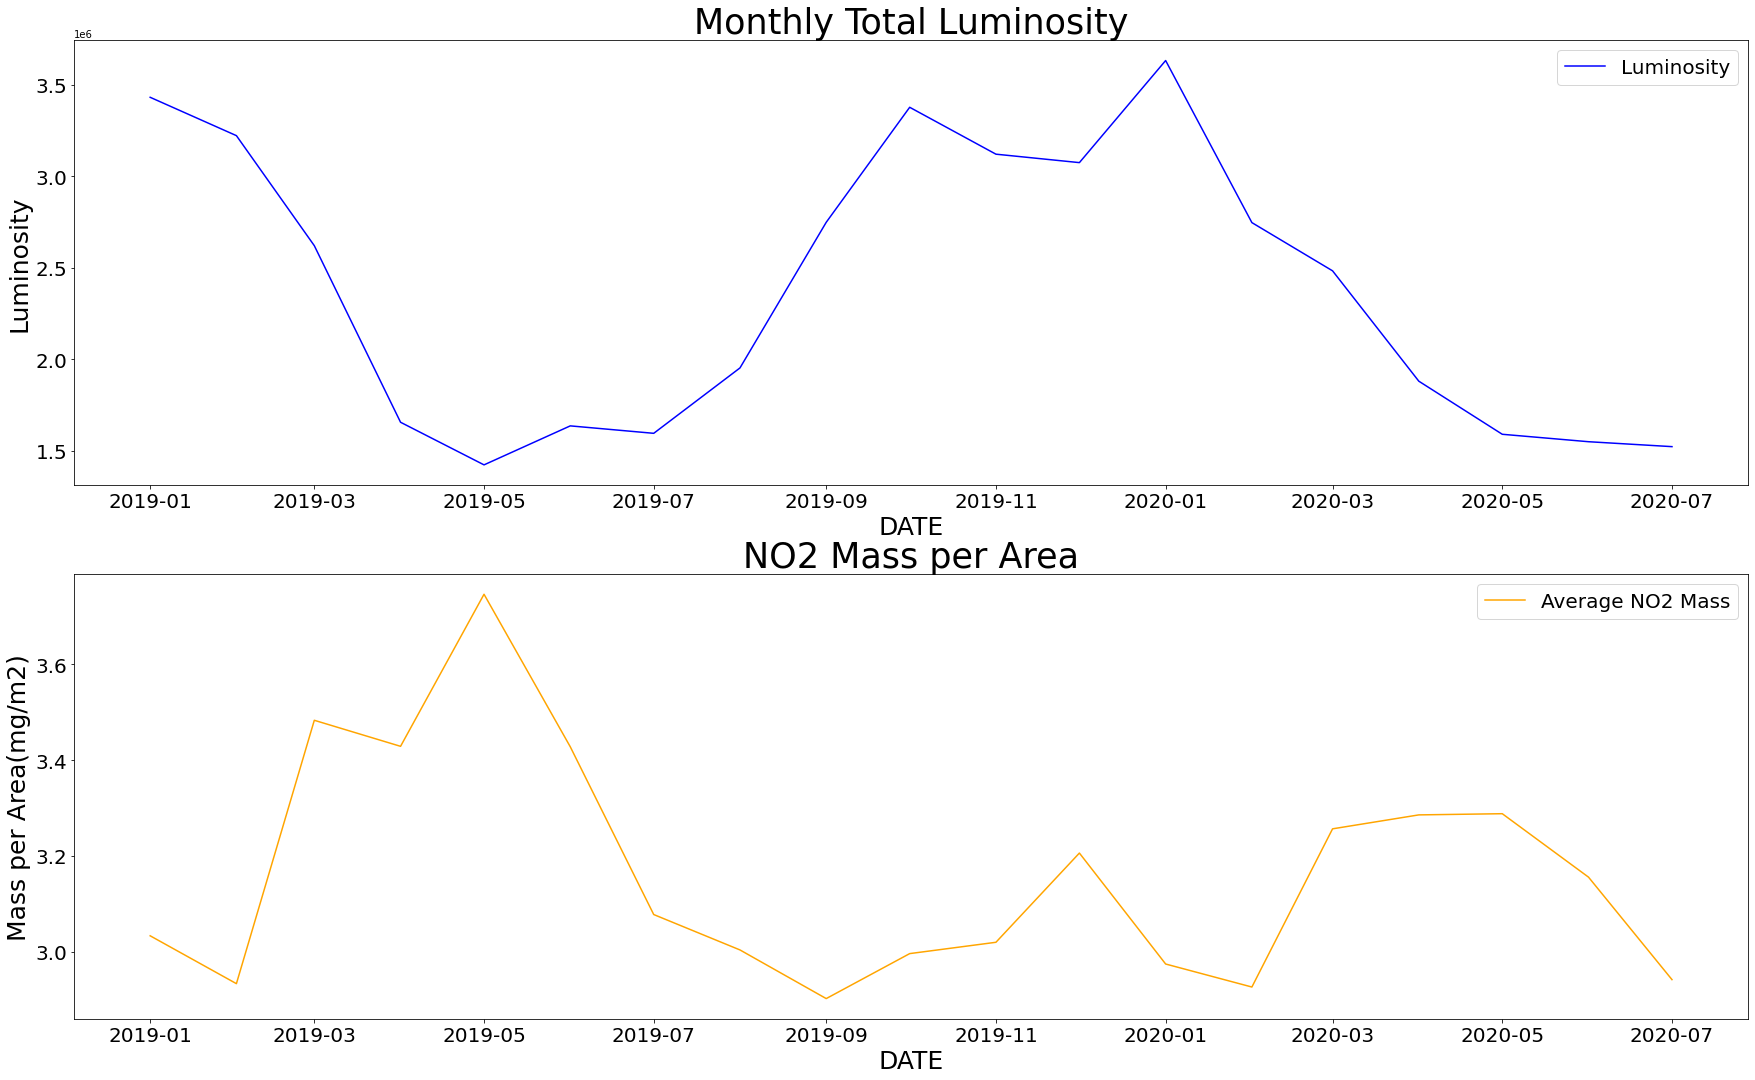

In [25]:
df_gb['DATE'] = pd.to_datetime(df_gb.YEAR.astype(str)+' '+ df_gb.MONTH.astype(str))
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30, 18))

# Plotting the monthly log luminosity 
ax0 = sns.lineplot(data=df_gb, x='DATE', y='LUMINOSITY_SUM', color='blue', label='Luminosity', ci=None, ax=axes[0])
ax0.set_xlabel('DATE', fontsize=25)
ax0.set_ylabel('Luminosity', fontsize=25)
ax0.set_title(f"Monthly Total Luminosity", 
                fontsize=35)
ax0.tick_params(axis='both', which='major', labelsize=20)
ax0.tick_params(axis='both', which='minor', labelsize=15)
ax0.legend(loc='best', fontsize=20)     

# Plotting the monthly log luminosity 
ax1 = sns.lineplot(data=df_gb, x='DATE', y='NO2_AVERAGE_MASS', color='orange', label='Average NO2 Mass', ci=None, ax=axes[1])
ax1.set_xlabel('DATE', fontsize=25)
ax1.set_ylabel('Mass per Area(mg/m2)', fontsize=25)
ax1.set_title(f"NO2 Mass per Area", 
                fontsize=35)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.legend(loc='best', fontsize=20)     


plt.show()
